1.Deep Learning.
a. Build a DNN with five hidden layers of 100 neurons each, He initialization, and the
ELU activation function.
b. Using Adam optimization and early stopping, try training it on MNIST but only on
digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You
will need a softmax output layer with five neurons, and as always make sure to save
checkpoints at regular intervals and save the final model so you can reuse it later.
c. Tune the hyperparameters using cross-validation and see what precision you can
achieve.
d. Now try adding Batch Normalization and compare the learning curves: is it
converging faster than before? Does it produce a better model?
e. Is the model overfitting the training set? Try adding dropout to every layer and try
again. Does it help?

#a. Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function.

import numpy as np
import tensorflow as tf
from functools import partial
he_init = tf.contrib.layers.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

#b.Using Adam optimization and early stopping, try training it on MNIST but only on
digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You
will need a softmax output layer with five neurons, and as always make sure to save
checkpoints at regular intervals and save the final model so you can reuse it later.

#Let's complete the graph with the cost function, the training op, and all the other usual components:

learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

#Let's fetch the MNIST dataset:

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz

#Now let's create the training set, validation and test set (we need the validation set to implement early stopping):


X_train1 = mnist.train.images[mnist.train.labels < 5]
y_train1 = mnist.train.labels[mnist.train.labels < 5]
X_valid1 = mnist.validation.images[mnist.validation.labels < 5]
y_valid1 = mnist.validation.labels[mnist.validation.labels < 5]
X_test1 = mnist.test.images[mnist.test.labels < 5]
y_test1 = mnist.test.labels[mnist.test.labels < 5]

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.128663	Best loss: 0.128663	Accuracy: 96.64%
1	Validation loss: 0.448317	Best loss: 0.128663	Accuracy: 78.19%
2	Validation loss: 0.190859	Best loss: 0.128663	Accuracy: 95.54%
3	Validation loss: 0.146951	Best loss: 0.128663	Accuracy: 96.79%
4	Validation loss: 0.086076	Best loss: 0.086076	Accuracy: 97.69%
5	Validation loss: 0.115353	Best loss: 0.086076	Accuracy: 97.77%
6	Validation loss: 0.239142	Best loss: 0.086076	Accuracy: 95.15%
7	Validation loss: 0.088810	Best loss: 0.086076	Accuracy: 98.12%
8	Validation loss: 0.108763	Best loss: 0.086076	Accuracy: 97.81%
9	Validation loss: 0.300808	Best loss: 0.086076	Accuracy: 96.17%
10	Validation loss: 0.179260	Best loss: 0.086076	Accuracy: 97.46%
11	Validation loss: 0.125690	Best loss: 0.086076	Accuracy: 98.48%
12	Validation loss: 0.738371	Best loss: 0.086076	Accuracy: 77.72%
13	Validation loss: 1.894743	Best loss: 0.086076	Accuracy: 78.54%
14	Validation loss: 0.415678	Best loss: 0.086076	Accuracy: 78.50%
15	Validation loss: 0.537646	Best loss: 0.086076	Accuracy: 75.45%
16	Validation loss: 1.009708	Best loss: 0.086076	Accuracy: 53.99%
17	Validation loss: 1.228350	Best loss: 0.086076	Accuracy: 38.15%
18	Validation loss: 1.510606	Best loss: 0.086076	Accuracy: 29.44%
19	Validation loss: 1.632344	Best loss: 0.086076	Accuracy: 22.01%
20	Validation loss: 1.628246	Best loss: 0.086076	Accuracy: 22.01%
21	Validation loss: 1.626765	Best loss: 0.086076	Accuracy: 22.01%
22	Validation loss: 1.651615	Best loss: 0.086076	Accuracy: 18.73%
23	Validation loss: 1.663751	Best loss: 0.086076	Accuracy: 19.27%
24	Validation loss: 1.675138	Best loss: 0.086076	Accuracy: 22.01%
Early stopping!
INFO:tensorflow:Restoring parameters from ./my_mnist_model_0_to_4.ckpt
Final test accuracy: 98.05%

#We get 98.05% accuracy on the test set. That's not too bad, but let's see if we can do better by tuning the hyperparameters.

#c. Tune the hyperparameters using cross-validation and see what precision you can achieve.

Let's create a DNNClassifier class, compatible with Scikit-Learn's RandomizedSearchCV class, to perform hyperparameter tuning. Here are the key points of this implementation:

the __init__() method (constructor) does nothing more than create instance variables for each of the hyperparameters.
the fit() method creates the graph, starts a session and trains the model:
it calls the _build_graph() method to build the graph (much lile the graph we defined earlier). Once this method is done creating the graph, it saves all the important operations as instance variables for easy access by other methods.
the _dnn() method builds the hidden layers, just like the dnn() function above, but also with support for batch normalization and dropout (for the next exercises).
if the fit() method is given a validation set (X_valid and y_valid), then it implements early stopping. This implementation does not save the best model to disk, but rather to memory: it uses the _get_model_params() method to get all the graph's variables and their values, and the _restore_model_params() method to restore the variable values (of the best model found). This trick helps speed up training.
After the fit() method has finished training the model, it keeps the session open so that predictions can be made quickly, without having to save a model to disk and restore it for every prediction. You can close the session by calling the close_session() method.
the predict_proba() method uses the trained model to predict the class probabilities.
the predict() method calls predict_proba() and returns the class with the highest probability, for each instance.

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None

        # extra ops for batch normalization
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

#Let's see if we get the exact same accuracy as earlier using this class (without dropout or batch norm):

dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.128663	Best loss: 0.128663	Accuracy: 96.64%
1	Validation loss: 0.448317	Best loss: 0.128663	Accuracy: 78.19%
2	Validation loss: 0.190859	Best loss: 0.128663	Accuracy: 95.54%
3	Validation loss: 0.146951	Best loss: 0.128663	Accuracy: 96.79%
4	Validation loss: 0.086076	Best loss: 0.086076	Accuracy: 97.69%
5	Validation loss: 0.115353	Best loss: 0.086076	Accuracy: 97.77%
6	Validation loss: 0.239142	Best loss: 0.086076	Accuracy: 95.15%
7	Validation loss: 0.088810	Best loss: 0.086076	Accuracy: 98.12%
8	Validation loss: 0.108763	Best loss: 0.086076	Accuracy: 97.81%
9	Validation loss: 0.300808	Best loss: 0.086076	Accuracy: 96.17%
10	Validation loss: 0.179260	Best loss: 0.086076	Accuracy: 97.46%
11	Validation loss: 0.125690	Best loss: 0.086076	Accuracy: 98.48%
12	Validation loss: 0.738371	Best loss: 0.086076	Accuracy: 77.72%
13	Validation loss: 1.894743	Best loss: 0.086076	Accuracy: 78.54%
14	Validation loss: 0.415678	Best loss: 0.086076	Accuracy: 78.50%
15	Validation loss: 0.537646	Best loss: 0.086076	Accuracy: 75.45%
16	Validation loss: 1.009708	Best loss: 0.086076	Accuracy: 53.99%
17	Validation loss: 1.228350	Best loss: 0.086076	Accuracy: 38.15%
18	Validation loss: 1.510606	Best loss: 0.086076	Accuracy: 29.44%
19	Validation loss: 1.632344	Best loss: 0.086076	Accuracy: 22.01%
20	Validation loss: 1.628246	Best loss: 0.086076	Accuracy: 22.01%
21	Validation loss: 1.626765	Best loss: 0.086076	Accuracy: 22.01%
22	Validation loss: 1.651615	Best loss: 0.086076	Accuracy: 18.73%
23	Validation loss: 1.663751	Best loss: 0.086076	Accuracy: 19.27%
24	Validation loss: 1.675138	Best loss: 0.086076	Accuracy: 22.01%
25	Validation loss: 1.743664	Best loss: 0.086076	Accuracy: 18.73%
Early stopping!

DNNClassifier(activation=<function elu at 0x7f8e3a484268>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f8e143c3840>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

#The model is trained, let's see if it gets the same accuracy as earlier:

from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.98054096127651291

It is working fine. Now we can use Scikit-Learn's RandomizedSearchCV class to search for better hyperparameters (this may take over an hour, depending on your system):

from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] learning_rate=0.05, batch_size=100, n_neurons=10, activation=<function elu at 0x7f8e3a484268> 
0	Validation loss: 0.132355	Best loss: 0.132355	Accuracy: 96.44%
1	Validation loss: 0.126329	Best loss: 0.126329	Accuracy: 96.21%
2	Validation loss: 0.138284	Best loss: 0.126329	Accuracy: 96.76%
3	Validation loss: 0.142094	Best loss: 0.126329	Accuracy: 96.25%
4	Validation loss: 0.128141	Best loss: 0.126329	Accuracy: 96.76%
5	Validation loss: 0.119928	Best loss: 0.119928	Accuracy: 97.26%
6	Validation loss: 0.137134	Best loss: 0.119928	Accuracy: 96.72%
7	Validation loss: 0.156194	Best loss: 0.119928	Accuracy: 96.79%
8	Validation loss: 0.283938	Best loss: 0.119928	Accuracy: 94.53%
9	Validation loss: 1.104801	Best loss: 0.119928	Accuracy: 52.38%
10	Validation loss: 0.966833	Best loss: 0.119928	Accuracy: 53.09%
11	Validation loss: 0.854368	Best loss: 0.119928	Accuracy: 57.47%
12	Validation loss: 1.857330	Best loss: 0.119928	Accuracy: 38.98%
13	Validation loss: 1.642338	Best loss: 0.119928	Accuracy: 18.73%
14	Validation loss: 1.612854	Best loss: 0.119928	Accuracy: 22.01%
15	Validation loss: 1.617682	Best loss: 0.119928	Accuracy: 22.01%
16	Validation loss: 1.616873	Best loss: 0.119928	Accuracy: 22.01%
17	Validation loss: 1.618228	Best loss: 0.119928	Accuracy: 19.27%
18	Validation loss: 1.619055	Best loss: 0.119928	Accuracy: 19.27%
19	Validation loss: 1.643334	Best loss: 0.119928	Accuracy: 19.08%
20	Validation loss: 1.621200	Best loss: 0.119928	Accuracy: 19.08%
21	Validation loss: 1.629823	Best loss: 0.119928	Accuracy: 19.27%
22	Validation loss: 1.624553	Best loss: 0.119928	Accuracy: 18.73%
23	Validation loss: 1.610214	Best loss: 0.119928	Accuracy: 20.91%
24	Validation loss: 1.621143	Best loss: 0.119928	Accuracy: 22.01%
25	Validation loss: 1.623761	Best loss: 0.119928	Accuracy: 22.01%
26	Validation loss: 1.641760	Best loss: 0.119928	Accuracy: 18.73%
Early stopping!
[CV]  learning_rate=0.05, batch_size=100, n_neurons=10, activation=<function elu at 0x7f8e3a484268>, total=   6.5s
[CV] learning_rate=0.05, batch_size=100, n_neurons=10, activation=<function elu at 0x7f8e3a484268> 
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
0	Validation loss: 0.153707	Best loss: 0.153707	Accuracy: 95.74%
1	Validation loss: 0.120703	Best loss: 0.120703	Accuracy: 96.56%
2	Validation loss: 0.164706	Best loss: 0.120703	Accuracy: 96.05%
3	Validation loss: 0.177875	Best loss: 0.120703	Accuracy: 95.19%
4	Validation loss: 0.171004	Best loss: 0.120703	Accuracy: 95.19%
5	Validation loss: 0.114746	Best loss: 0.114746	Accuracy: 96.83%
6	Validation loss: 0.109637	Best loss: 0.109637	Accuracy: 97.26%
7	Validation loss: 0.261533	Best loss: 0.109637	Accuracy: 94.96%
8	Validation loss: 0.316743	Best loss: 0.109637	Accuracy: 94.02%
9	Validation loss: 0.486484	Best loss: 0.109637	Accuracy: 77.56%
10	Validation loss: 4.635532	Best loss: 0.109637	Accuracy: 53.95%
11	Validation loss: 1.172422	Best loss: 0.109637	Accuracy: 48.36%
12	Validation loss: 1.029865	Best loss: 0.109637	Accuracy: 55.98%
13	Validation loss: 1.298800	Best loss: 0.109637	Accuracy: 36.08%
14	Validation loss: 1.141950	Best loss: 0.109637	Accuracy: 38.08%
15	Validation loss: 1.132486	Best loss: 0.109637	Accuracy: 38.90%
16	Validation loss: 1.078486	Best loss: 0.109637	Accuracy: 45.78%
17	Validation loss: 1.128344	Best loss: 0.109637	Accuracy: 45.07%
18	Validation loss: 1.336244	Best loss: 0.109637	Accuracy: 34.40%
19	Validation loss: 1.199178	Best loss: 0.109637	Accuracy: 39.87%
20	Validation loss: 1.175845	Best loss: 0.109637	Accuracy: 40.11%
21	Validation loss: 1.200430	Best loss: 0.109637	Accuracy: 40.30%
22	Validation loss: 1.390084	Best loss: 0.109637	Accuracy: 34.60%
23	Validation loss: 1.268129	Best loss: 0.109637	Accuracy: 40.23%
24	Validation loss: 1.192210	Best loss: 0.109637	Accuracy: 40.30%
25	Validation loss: 1.190541	Best loss: 0.109637	Accuracy: 41.99%
26	Validation loss: 1.227676	Best loss: 0.109637	Accuracy: 38.62%
27	Validation loss: 1.187587	Best loss: 0.109637	Accuracy: 39.44%
Early stopping!
[CV]  learning_rate=0.05, batch_size=100, n_neurons=10, activation=<function elu at 0x7f8e3a484268>, total=   6.6s
[CV] learning_rate=0.05, batch_size=100, n_neurons=10, activation=<function elu at 0x7f8e3a484268> 
0	Validation loss: 0.182619	Best loss: 0.182619	Accuracy: 94.29%
1	Validation loss: 0.152706	Best loss: 0.152706	Accuracy: 95.97%
2	Validation loss: 0.193820	Best loss: 0.152706	Accuracy: 93.82%
3	Validation loss: 0.195413	Best loss: 0.152706	Accuracy: 95.54%
4	Validation loss: 0.171277	Best loss: 0.152706	Accuracy: 95.19%
5	Validation loss: 0.140087	Best loss: 0.140087	Accuracy: 95.70%
6	Validation loss: 0.170798	Best loss: 0.140087	Accuracy: 95.00%
7	Validation loss: 0.163649	Best loss: 0.140087	Accuracy: 96.29%
8	Validation loss: 0.199048	Best loss: 0.140087	Accuracy: 96.09%
9	Validation loss: 1.552870	Best loss: 0.140087	Accuracy: 52.15%
10	Validation loss: 0.813273	Best loss: 0.140087	Accuracy: 60.40%
11	Validation loss: 0.775555	Best loss: 0.140087	Accuracy: 60.67%
12	Validation loss: 0.775275	Best loss: 0.140087	Accuracy: 59.77%
13	Validation loss: 0.770521	Best loss: 0.140087	Accuracy: 59.30%
14	Validation loss: 0.734035	Best loss: 0.140087	Accuracy: 59.85%
15	Validation loss: 0.744980	Best loss: 0.140087	Accuracy: 59.66%
16	Validation loss: 0.785848	Best loss: 0.140087	Accuracy: 59.66%
17	Validation loss: 0.776138	Best loss: 0.140087	Accuracy: 59.42%
18	Validation loss: 0.764496	Best loss: 0.140087	Accuracy: 59.46%
19	Validation loss: 0.763633	Best loss: 0.140087	Accuracy: 59.54%
20	Validation loss: 0.743879	Best loss: 0.140087	Accuracy: 60.75%
21	Validation loss: 0.763295	Best loss: 0.140087	Accuracy: 60.36%
22	Validation loss: 0.717175	Best loss: 0.140087	Accuracy: 60.63%
23	Validation loss: 1.869954	Best loss: 0.140087	Accuracy: 29.28%
24	Validation loss: 1.215518	Best loss: 0.140087	Accuracy: 38.86%
25	Validation loss: 1.196626	Best loss: 0.140087	Accuracy: 38.62%
26	Validation loss: 1.170714	Best loss: 0.140087	Accuracy: 42.38%
Early stopping!
[CV]  learning_rate=0.05, batch_size=100, n_neurons=10, activation=<function elu at 0x7f8e3a484268>, total=   7.3s
[CV] learning_rate=0.02, batch_size=500, n_neurons=30, activation=<function relu at 0x7f8e3a410268> 
0	Validation loss: 0.171512	Best loss: 0.171512	Accuracy: 95.07%
1	Validation loss: 0.095914	Best loss: 0.095914	Accuracy: 97.03%
2	Validation loss: 0.099199	Best loss: 0.095914	Accuracy: 96.91%
3	Validation loss: 0.093873	Best loss: 0.093873	Accuracy: 97.15%
4	Validation loss: 0.073461	Best loss: 0.073461	Accuracy: 98.01%
5	Validation loss: 0.084562	Best loss: 0.073461	Accuracy: 97.65%
6	Validation loss: 0.071800	Best loss: 0.071800	Accuracy: 98.01%
7	Validation loss: 0.088435	Best loss: 0.071800	Accuracy: 97.73%
8	Validation loss: 0.082038	Best loss: 0.071800	Accuracy: 97.77%
9	Validation loss: 0.080673	Best loss: 0.071800	Accuracy: 97.69%
10	Validation loss: 0.081036	Best loss: 0.071800	Accuracy: 97.93%
11	Validation loss: 0.092700	Best loss: 0.071800	Accuracy: 97.93%
12	Validation loss: 0.081003	Best loss: 0.071800	Accuracy: 98.20%
13	Validation loss: 0.075607	Best loss: 0.071800	Accuracy: 98.20%
14	Validation loss: 0.092970	Best loss: 0.071800	Accuracy: 98.08%
15	Validation loss: 0.108005	Best loss: 0.071800	Accuracy: 97.77%
16	Validation loss: 0.082602	Best loss: 0.071800	Accuracy: 98.05%
17	Validation loss: 0.114629	Best loss: 0.071800	Accuracy: 97.73%
18	Validation loss: 0.099099	Best loss: 0.071800	Accuracy: 97.69%
19	Validation loss: 0.075535	Best loss: 0.071800	Accuracy: 98.20%
20	Validation loss: 0.102847	Best loss: 0.071800	Accuracy: 98.08%
21	Validation loss: 0.089735	Best loss: 0.071800	Accuracy: 98.36%
22	Validation loss: 0.080781	Best loss: 0.071800	Accuracy: 97.93%
23	Validation loss: 0.073017	Best loss: 0.071800	Accuracy: 98.32%
24	Validation loss: 0.091643	Best loss: 0.071800	Accuracy: 97.93%
25	Validation loss: 0.113891	Best loss: 0.071800	Accuracy: 98.05%
26	Validation loss: 0.094774	Best loss: 0.071800	Accuracy: 98.28%
27	Validation loss: 0.086041	Best loss: 0.071800	Accuracy: 98.20%
Early stopping!
[CV]  learning_rate=0.02, batch_size=500, n_neurons=30, activation=<function relu at 0x7f8e3a410268>, total=   7.9s
[CV] learning_rate=0.02, batch_size=500, n_neurons=30, activation=<function relu at 0x7f8e3a410268> 
0	Validation loss: 0.113188	Best loss: 0.113188	Accuracy: 96.60%
1	Validation loss: 0.081384	Best loss: 0.081384	Accuracy: 97.58%
2	Validation loss: 0.068770	Best loss: 0.068770	Accuracy: 98.12%
3	Validation loss: 0.077316	Best loss: 0.068770	Accuracy: 97.73%
[...and much later...]
43	Validation loss: 6167.386230	Best loss: 0.142484	Accuracy: 91.83%
44	Validation loss: 19455.550781	Best loss: 0.142484	Accuracy: 84.75%
45	Validation loss: 8478.734375	Best loss: 0.142484	Accuracy: 92.26%
46	Validation loss: 7594.540039	Best loss: 0.142484	Accuracy: 91.79%
47	Validation loss: 18661.273438	Best loss: 0.142484	Accuracy: 90.15%
48	Validation loss: 10774.322266	Best loss: 0.142484	Accuracy: 93.28%
49	Validation loss: 8555.013672	Best loss: 0.142484	Accuracy: 92.03%
Early stopping!
[CV]  learning_rate=0.1, batch_size=500, n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e23bc8488>, total=  33.8s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 80.5min finished
0	Validation loss: 0.090732	Best loss: 0.090732	Accuracy: 97.22%
1	Validation loss: 0.052198	Best loss: 0.052198	Accuracy: 98.40%
2	Validation loss: 0.040040	Best loss: 0.040040	Accuracy: 98.94%
3	Validation loss: 0.057495	Best loss: 0.040040	Accuracy: 98.55%
4	Validation loss: 0.045600	Best loss: 0.040040	Accuracy: 98.75%
5	Validation loss: 0.062344	Best loss: 0.040040	Accuracy: 98.48%
6	Validation loss: 0.048719	Best loss: 0.040040	Accuracy: 98.67%
7	Validation loss: 0.050346	Best loss: 0.040040	Accuracy: 98.79%
8	Validation loss: 0.051224	Best loss: 0.040040	Accuracy: 98.79%
9	Validation loss: 0.036505	Best loss: 0.036505	Accuracy: 98.98%
10	Validation loss: 0.052532	Best loss: 0.036505	Accuracy: 98.71%
11	Validation loss: 0.057086	Best loss: 0.036505	Accuracy: 99.10%
12	Validation loss: 0.036754	Best loss: 0.036505	Accuracy: 99.06%
13	Validation loss: 0.046782	Best loss: 0.036505	Accuracy: 98.87%
14	Validation loss: 0.048929	Best loss: 0.036505	Accuracy: 98.91%
15	Validation loss: 0.052919	Best loss: 0.036505	Accuracy: 98.75%
16	Validation loss: 0.054287	Best loss: 0.036505	Accuracy: 98.67%
17	Validation loss: 0.047722	Best loss: 0.036505	Accuracy: 98.79%
18	Validation loss: 0.040474	Best loss: 0.036505	Accuracy: 99.14%
19	Validation loss: 0.033867	Best loss: 0.033867	Accuracy: 99.14%
20	Validation loss: 0.046808	Best loss: 0.033867	Accuracy: 98.83%
21	Validation loss: 0.052966	Best loss: 0.033867	Accuracy: 98.91%
22	Validation loss: 0.095892	Best loss: 0.033867	Accuracy: 98.08%
23	Validation loss: 0.054250	Best loss: 0.033867	Accuracy: 98.87%
24	Validation loss: 0.061026	Best loss: 0.033867	Accuracy: 98.87%
25	Validation loss: 0.081977	Best loss: 0.033867	Accuracy: 98.67%
26	Validation loss: 0.079819	Best loss: 0.033867	Accuracy: 98.71%
27	Validation loss: 0.059824	Best loss: 0.033867	Accuracy: 98.75%
28	Validation loss: 0.057758	Best loss: 0.033867	Accuracy: 98.94%
29	Validation loss: 0.087165	Best loss: 0.033867	Accuracy: 98.91%
30	Validation loss: 0.052274	Best loss: 0.033867	Accuracy: 99.10%
31	Validation loss: 0.059831	Best loss: 0.033867	Accuracy: 98.79%
32	Validation loss: 0.054240	Best loss: 0.033867	Accuracy: 98.91%
33	Validation loss: 0.048165	Best loss: 0.033867	Accuracy: 98.94%
34	Validation loss: 0.040565	Best loss: 0.033867	Accuracy: 99.18%
35	Validation loss: 0.103207	Best loss: 0.033867	Accuracy: 98.28%
36	Validation loss: 400.716797	Best loss: 0.033867	Accuracy: 71.46%
37	Validation loss: 11.996887	Best loss: 0.033867	Accuracy: 96.09%
38	Validation loss: 2.623182	Best loss: 0.033867	Accuracy: 96.56%
39	Validation loss: 1.344962	Best loss: 0.033867	Accuracy: 97.69%
40	Validation loss: 1.125381	Best loss: 0.033867	Accuracy: 97.42%
Early stopping!
Out[116]:
RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7f8e3a484268>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f8e143c3840>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'n_epochs': 1000, 'X_valid': array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]], dtype=float32), 'y_valid': array([0, 4, ..., 1, 2], dtype=uint8)},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'activation': [<function relu at 0x7f8e3a410268>, <function elu at 0x7f8e3a484268>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e4469d510>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e23bc8488>]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

rnd_search.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 500,
 'learning_rate': 0.01,
 'n_neurons': 140}

y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99318933644677954

Tuning the hyperparameters got us up to 99.32% accuracy! It may not sound like a great improvement to go from 98.05% to 99.32% accuracy, but consider the error rate: it went from roughly 2% to 0.7%. That's a 65% reduction of the number of errors this model will produce!

It's a good idea to save this model:

rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

#d. Now try adding Batch Normalization and compare the learning curves: is it
converging faster than before? Does it produce a better model?

#Let's train the best model found, once again, to see how fast it converges (alternatively, you could tweak the code above to make it write summaries for TensorBoard, so you can visualize the learning curve):


dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.090732	Best loss: 0.090732	Accuracy: 97.22%
1	Validation loss: 0.052198	Best loss: 0.052198	Accuracy: 98.40%
2	Validation loss: 0.040040	Best loss: 0.040040	Accuracy: 98.94%
3	Validation loss: 0.057495	Best loss: 0.040040	Accuracy: 98.55%
4	Validation loss: 0.045600	Best loss: 0.040040	Accuracy: 98.75%
5	Validation loss: 0.062344	Best loss: 0.040040	Accuracy: 98.48%
6	Validation loss: 0.048719	Best loss: 0.040040	Accuracy: 98.67%
7	Validation loss: 0.050346	Best loss: 0.040040	Accuracy: 98.79%
8	Validation loss: 0.051224	Best loss: 0.040040	Accuracy: 98.79%
9	Validation loss: 0.036505	Best loss: 0.036505	Accuracy: 98.98%
10	Validation loss: 0.052532	Best loss: 0.036505	Accuracy: 98.71%
11	Validation loss: 0.057086	Best loss: 0.036505	Accuracy: 99.10%
12	Validation loss: 0.036754	Best loss: 0.036505	Accuracy: 99.06%
13	Validation loss: 0.046782	Best loss: 0.036505	Accuracy: 98.87%
14	Validation loss: 0.048929	Best loss: 0.036505	Accuracy: 98.91%
15	Validation loss: 0.052919	Best loss: 0.036505	Accuracy: 98.75%
16	Validation loss: 0.054287	Best loss: 0.036505	Accuracy: 98.67%
17	Validation loss: 0.047722	Best loss: 0.036505	Accuracy: 98.79%
18	Validation loss: 0.040474	Best loss: 0.036505	Accuracy: 99.14%
19	Validation loss: 0.033867	Best loss: 0.033867	Accuracy: 99.14%
20	Validation loss: 0.046808	Best loss: 0.033867	Accuracy: 98.83%
21	Validation loss: 0.052966	Best loss: 0.033867	Accuracy: 98.91%
22	Validation loss: 0.095892	Best loss: 0.033867	Accuracy: 98.08%
23	Validation loss: 0.054250	Best loss: 0.033867	Accuracy: 98.87%
24	Validation loss: 0.061026	Best loss: 0.033867	Accuracy: 98.87%
25	Validation loss: 0.081977	Best loss: 0.033867	Accuracy: 98.67%
26	Validation loss: 0.079819	Best loss: 0.033867	Accuracy: 98.71%
27	Validation loss: 0.059824	Best loss: 0.033867	Accuracy: 98.75%
28	Validation loss: 0.057758	Best loss: 0.033867	Accuracy: 98.94%
29	Validation loss: 0.087165	Best loss: 0.033867	Accuracy: 98.91%
30	Validation loss: 0.052274	Best loss: 0.033867	Accuracy: 99.10%
31	Validation loss: 0.059831	Best loss: 0.033867	Accuracy: 98.79%
32	Validation loss: 0.054240	Best loss: 0.033867	Accuracy: 98.91%
33	Validation loss: 0.048165	Best loss: 0.033867	Accuracy: 98.94%
34	Validation loss: 0.040565	Best loss: 0.033867	Accuracy: 99.18%
35	Validation loss: 0.103207	Best loss: 0.033867	Accuracy: 98.28%
36	Validation loss: 400.716797	Best loss: 0.033867	Accuracy: 71.46%
37	Validation loss: 11.996887	Best loss: 0.033867	Accuracy: 96.09%
38	Validation loss: 2.623182	Best loss: 0.033867	Accuracy: 96.56%
39	Validation loss: 1.344962	Best loss: 0.033867	Accuracy: 97.69%
40	Validation loss: 1.125381	Best loss: 0.033867	Accuracy: 97.42%
Early stopping!

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e23b8eae8>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f8e143c3840>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

#The best loss is reached at epoch 19, but it was already within 10% of that result at epoch 9.

#Let's check that we do indeed get 99.32% accuracy on the test set:

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99318933644677954

#now let's use the exact same model, but this time with batch normalization:

dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 1.857111	Best loss: 1.857111	Accuracy: 89.64%
1	Validation loss: 1.429800	Best loss: 1.429800	Accuracy: 93.94%
2	Validation loss: 0.984367	Best loss: 0.984367	Accuracy: 95.86%
3	Validation loss: 1.878914	Best loss: 0.984367	Accuracy: 94.68%
4	Validation loss: 4.285415	Best loss: 0.984367	Accuracy: 91.87%
5	Validation loss: 3.880259	Best loss: 0.984367	Accuracy: 91.91%
6	Validation loss: 7.586149	Best loss: 0.984367	Accuracy: 90.38%
7	Validation loss: 7.003541	Best loss: 0.984367	Accuracy: 91.05%
8	Validation loss: 3.774627	Best loss: 0.984367	Accuracy: 95.00%
9	Validation loss: 9.261741	Best loss: 0.984367	Accuracy: 90.66%
10	Validation loss: 4.659614	Best loss: 0.984367	Accuracy: 96.36%
11	Validation loss: 7.396369	Best loss: 0.984367	Accuracy: 94.21%
12	Validation loss: 10.800961	Best loss: 0.984367	Accuracy: 93.28%
13	Validation loss: 10.187258	Best loss: 0.984367	Accuracy: 94.68%
14	Validation loss: 12.643840	Best loss: 0.984367	Accuracy: 94.53%
15	Validation loss: 7.875628	Best loss: 0.984367	Accuracy: 96.13%
16	Validation loss: 30.227692	Best loss: 0.984367	Accuracy: 91.01%
17	Validation loss: 13.996559	Best loss: 0.984367	Accuracy: 95.62%
18	Validation loss: 14.688783	Best loss: 0.984367	Accuracy: 95.39%
19	Validation loss: 17.478910	Best loss: 0.984367	Accuracy: 95.66%
20	Validation loss: 20.260157	Best loss: 0.984367	Accuracy: 95.50%
21	Validation loss: 26.706875	Best loss: 0.984367	Accuracy: 94.18%
22	Validation loss: 28.201635	Best loss: 0.984367	Accuracy: 93.78%
23	Validation loss: 33.353935	Best loss: 0.984367	Accuracy: 93.98%
Early stopping!

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e23b8ed90>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f8e143c3840>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

#The best params are reached during epoch 2, that's much faster than earlier. Let's check the accuracy:

y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.95504962054874487

Well, batch normalization did not improve accuracy, quite the contrary. Let's see if we can find a good set of hyperparameters that will work well with batch normalization:

from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, n_neurons=70, activation=<function relu at 0x7f8e3a410268> 
0	Validation loss: 6.269045	Best loss: 6.269045	Accuracy: 93.24%
1	Validation loss: 25.152470	Best loss: 6.269045	Accuracy: 92.18%
2	Validation loss: 64.989517	Best loss: 6.269045	Accuracy: 92.46%
3	Validation loss: 60.365185	Best loss: 6.269045	Accuracy: 94.88%
4	Validation loss: 72.011459	Best loss: 6.269045	Accuracy: 96.79%
5	Validation loss: 428.570953	Best loss: 6.269045	Accuracy: 88.04%
6	Validation loss: 457.729675	Best loss: 6.269045	Accuracy: 92.81%
7	Validation loss: 555.036926	Best loss: 6.269045	Accuracy: 95.70%
8	Validation loss: 853.278564	Best loss: 6.269045	Accuracy: 94.45%
9	Validation loss: 1640.808838	Best loss: 6.269045	Accuracy: 93.67%
10	Validation loss: 1686.829712	Best loss: 6.269045	Accuracy: 95.19%
11	Validation loss: 4588.815430	Best loss: 6.269045	Accuracy: 89.95%
12	Validation loss: 3353.238525	Best loss: 6.269045	Accuracy: 95.39%
13	Validation loss: 24193.548828	Best loss: 6.269045	Accuracy: 85.69%
14	Validation loss: 14681.817383	Best loss: 6.269045	Accuracy: 91.48%
15	Validation loss: 10670.790039	Best loss: 6.269045	Accuracy: 94.68%
16	Validation loss: 20749.412109	Best loss: 6.269045	Accuracy: 88.58%
17	Validation loss: 59897.656250	Best loss: 6.269045	Accuracy: 81.98%
18	Validation loss: 18592.509766	Best loss: 6.269045	Accuracy: 94.57%
19	Validation loss: 15117.732422	Best loss: 6.269045	Accuracy: 96.29%
20	Validation loss: 18595.556641	Best loss: 6.269045	Accuracy: 96.05%
21	Validation loss: 43803.089844	Best loss: 6.269045	Accuracy: 92.46%
Early stopping!
[CV]  learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, n_neurons=70, activation=<function relu at 0x7f8e3a410268>, total=  38.7s
[CV] learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, n_neurons=70, activation=<function relu at 0x7f8e3a410268> 
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.1s remaining:    0.0s
0	Validation loss: 10.505345	Best loss: 10.505345	Accuracy: 91.05%
1	Validation loss: 27.669804	Best loss: 10.505345	Accuracy: 90.30%
2	Validation loss: 70.166283	Best loss: 10.505345	Accuracy: 88.90%
3	Validation loss: 61.704323	Best loss: 10.505345	Accuracy: 94.92%
4	Validation loss: 175.554169	Best loss: 10.505345	Accuracy: 91.36%
5	Validation loss: 303.135834	Best loss: 10.505345	Accuracy: 92.65%
6	Validation loss: 589.975830	Best loss: 10.505345	Accuracy: 91.09%
7	Validation loss: 890.363159	Best loss: 10.505345	Accuracy: 92.77%
8	Validation loss: 1223.559570	Best loss: 10.505345	Accuracy: 93.04%
9	Validation loss: 2402.012207	Best loss: 10.505345	Accuracy: 91.71%
10	Validation loss: 3208.452393	Best loss: 10.505345	Accuracy: 92.53%
11	Validation loss: 3419.600830	Best loss: 10.505345	Accuracy: 95.15%
12	Validation loss: 2918.134277	Best loss: 10.505345	Accuracy: 94.14%
13	Validation loss: 19868.285156	Best loss: 10.505345	Accuracy: 88.12%
14	Validation loss: 24219.689453	Best loss: 10.505345	Accuracy: 90.38%
15	Validation loss: 15377.804688	Best loss: 10.505345	Accuracy: 91.36%
16	Validation loss: 43667.164062	Best loss: 10.505345	Accuracy: 89.41%
17	Validation loss: 66674.023438	Best loss: 10.505345	Accuracy: 86.08%
18	Validation loss: 74437.500000	Best loss: 10.505345	Accuracy: 87.69%
19	Validation loss: 84437.039062	Best loss: 10.505345	Accuracy: 88.12%
20	Validation loss: 56583.324219	Best loss: 10.505345	Accuracy: 92.34%
21	Validation loss: 98689.828125	Best loss: 10.505345	Accuracy: 89.91%
Early stopping!
[CV]  learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, n_neurons=70, activation=<function relu at 0x7f8e3a410268>, total=  38.2s
[CV] learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, n_neurons=70, activation=<function relu at 0x7f8e3a410268> 
0	Validation loss: 2.343517	Best loss: 2.343517	Accuracy: 96.25%
1	Validation loss: 23.652935	Best loss: 2.343517	Accuracy: 93.08%
2	Validation loss: 35.758228	Best loss: 2.343517	Accuracy: 93.12%
3	Validation loss: 123.383575	Best loss: 2.343517	Accuracy: 93.04%
4	Validation loss: 192.505844	Best loss: 2.343517	Accuracy: 93.08%
5	Validation loss: 678.043213	Best loss: 2.343517	Accuracy: 86.94%
6	Validation loss: 552.234924	Best loss: 2.343517	Accuracy: 92.03%
7	Validation loss: 1775.860107	Best loss: 2.343517	Accuracy: 89.13%
8	Validation loss: 1147.925293	Best loss: 2.343517	Accuracy: 93.20%
9	Validation loss: 2561.473389	Best loss: 2.343517	Accuracy: 91.01%
10	Validation loss: 7404.971191	Best loss: 2.343517	Accuracy: 85.18%
11	Validation loss: 3112.663330	Best loss: 2.343517	Accuracy: 93.35%
12	Validation loss: 8808.947266	Best loss: 2.343517	Accuracy: 87.88%
13	Validation loss: 8157.308594	Best loss: 2.343517	Accuracy: 90.11%
14	Validation loss: 14201.116211	Best loss: 2.343517	Accuracy: 89.37%
15	Validation loss: 43183.285156	Best loss: 2.343517	Accuracy: 81.04%
16	Validation loss: 40037.652344	Best loss: 2.343517	Accuracy: 84.71%
17	Validation loss: 18612.115234	Best loss: 2.343517	Accuracy: 92.46%
18	Validation loss: 50549.546875	Best loss: 2.343517	Accuracy: 87.02%
19	Validation loss: 52649.320312	Best loss: 2.343517	Accuracy: 90.66%
20	Validation loss: 162720.609375	Best loss: 2.343517	Accuracy: 84.36%
21	Validation loss: 78574.101562	Best loss: 2.343517	Accuracy: 88.94%
Early stopping!
[CV]  learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, n_neurons=70, activation=<function relu at 0x7f8e3a410268>, total=  38.0s
[CV] learning_rate=0.02, batch_size=10, batch_norm_momentum=0.9, n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e13cb4e18> 
0	Validation loss: 60438.898438	Best loss: 60438.898438	Accuracy: 81.94%
1	Validation loss: 300987.656250	Best loss: 60438.898438	Accuracy: 90.93%
2	Validation loss: 1377872.000000	Best loss: 60438.898438	Accuracy: 93.94%
3	Validation loss: 14642961.000000	Best loss: 60438.898438	Accuracy: 91.48%
4	Validation loss: 27300228.000000	Best loss: 60438.898438	Accuracy: 93.00%
5	Validation loss: 22168134.000000	Best loss: 60438.898438	Accuracy: 96.33%
6	Validation loss: 125345760.000000	Best loss: 60438.898438	Accuracy: 92.10%
7	Validation loss: 67775336.000000	Best loss: 60438.898438	Accuracy: 96.91%
8	Validation loss: 183302928.000000	Best loss: 60438.898438	Accuracy: 95.23%
9	Validation loss: 202538928.000000	Best loss: 60438.898438	Accuracy: 96.99%
10	Validation loss: 261316368.000000	Best loss: 60438.898438	Accuracy: 97.69%
11	Validation loss: 271426848.000000	Best loss: 60438.898438	Accuracy: 97.50%
12	Validation loss: 1200596480.000000	Best loss: 60438.898438	Accuracy: 95.93%
[...and much later...]
11	Validation loss: 169707792.000000	Best loss: 5764.423340	Accuracy: 96.60%
12	Validation loss: 729495616.000000	Best loss: 5764.423340	Accuracy: 95.04%
13	Validation loss: 1469533312.000000	Best loss: 5764.423340	Accuracy: 94.25%
14	Validation loss: 2399959552.000000	Best loss: 5764.423340	Accuracy: 96.25%
15	Validation loss: 4667502080.000000	Best loss: 5764.423340	Accuracy: 95.74%
16	Validation loss: 4580651520.000000	Best loss: 5764.423340	Accuracy: 95.86%
17	Validation loss: 9609373696.000000	Best loss: 5764.423340	Accuracy: 95.15%
18	Validation loss: 5375582720.000000	Best loss: 5764.423340	Accuracy: 95.93%
19	Validation loss: 88911585280.000000	Best loss: 5764.423340	Accuracy: 91.59%
20	Validation loss: 97645641728.000000	Best loss: 5764.423340	Accuracy: 92.18%
21	Validation loss: 92258205696.000000	Best loss: 5764.423340	Accuracy: 95.04%
Early stopping!
[CV]  learning_rate=0.05, batch_size=50, batch_norm_momentum=0.99, n_neurons=140, activation=<function elu at 0x7f8e3a484268>, total= 1.1min
[CV] learning_rate=0.05, batch_size=50, batch_norm_momentum=0.99, n_neurons=140, activation=<function elu at 0x7f8e3a484268> 
0	Validation loss: 8968.048828	Best loss: 8968.048828	Accuracy: 93.86%
1	Validation loss: 39933.992188	Best loss: 8968.048828	Accuracy: 92.53%
2	Validation loss: 125085.773438	Best loss: 8968.048828	Accuracy: 93.78%
3	Validation loss: 748332.187500	Best loss: 8968.048828	Accuracy: 88.43%
4	Validation loss: 2479649.000000	Best loss: 8968.048828	Accuracy: 93.51%
5	Validation loss: 4846857.500000	Best loss: 8968.048828	Accuracy: 94.18%
6	Validation loss: 29243816.000000	Best loss: 8968.048828	Accuracy: 87.72%
7	Validation loss: 130438520.000000	Best loss: 8968.048828	Accuracy: 82.92%
8	Validation loss: 163032112.000000	Best loss: 8968.048828	Accuracy: 87.06%
9	Validation loss: 295294496.000000	Best loss: 8968.048828	Accuracy: 83.54%
10	Validation loss: 1821488640.000000	Best loss: 8968.048828	Accuracy: 81.27%
11	Validation loss: 9158688768.000000	Best loss: 8968.048828	Accuracy: 76.15%
12	Validation loss: 9291267072.000000	Best loss: 8968.048828	Accuracy: 69.55%
13	Validation loss: 7129835520.000000	Best loss: 8968.048828	Accuracy: 76.35%
14	Validation loss: 9993897984.000000	Best loss: 8968.048828	Accuracy: 83.15%
15	Validation loss: 7655349248.000000	Best loss: 8968.048828	Accuracy: 85.81%
16	Validation loss: 27769886720.000000	Best loss: 8968.048828	Accuracy: 76.27%
17	Validation loss: 978719735808.000000	Best loss: 8968.048828	Accuracy: 49.30%
18	Validation loss: 220747595776.000000	Best loss: 8968.048828	Accuracy: 88.15%
19	Validation loss: 320542212096.000000	Best loss: 8968.048828	Accuracy: 86.16%
20	Validation loss: 349976592384.000000	Best loss: 8968.048828	Accuracy: 82.92%
21	Validation loss: 278264938496.000000	Best loss: 8968.048828	Accuracy: 84.68%
Early stopping!
[CV]  learning_rate=0.05, batch_size=50, batch_norm_momentum=0.99, n_neurons=140, activation=<function elu at 0x7f8e3a484268>, total= 1.1min
[CV] learning_rate=0.05, batch_size=50, batch_norm_momentum=0.99, n_neurons=140, activation=<function elu at 0x7f8e3a484268> 
0	Validation loss: 5885.549805	Best loss: 5885.549805	Accuracy: 95.11%
1	Validation loss: 80273.859375	Best loss: 5885.549805	Accuracy: 90.03%
2	Validation loss: 1050326.375000	Best loss: 5885.549805	Accuracy: 69.90%
3	Validation loss: 2969596.500000	Best loss: 5885.549805	Accuracy: 77.25%
4	Validation loss: 15399652.000000	Best loss: 5885.549805	Accuracy: 71.74%
5	Validation loss: 32421912.000000	Best loss: 5885.549805	Accuracy: 78.77%
6	Validation loss: 94322944.000000	Best loss: 5885.549805	Accuracy: 72.40%
7	Validation loss: 142864032.000000	Best loss: 5885.549805	Accuracy: 79.24%
8	Validation loss: 221855760.000000	Best loss: 5885.549805	Accuracy: 89.60%
9	Validation loss: 433116576.000000	Best loss: 5885.549805	Accuracy: 85.26%
10	Validation loss: 438715456.000000	Best loss: 5885.549805	Accuracy: 91.83%
11	Validation loss: 270049120.000000	Best loss: 5885.549805	Accuracy: 96.44%
12	Validation loss: 5670299648.000000	Best loss: 5885.549805	Accuracy: 82.10%
13	Validation loss: 4659497472.000000	Best loss: 5885.549805	Accuracy: 88.39%
14	Validation loss: 3080572928.000000	Best loss: 5885.549805	Accuracy: 90.73%
15	Validation loss: 3663905280.000000	Best loss: 5885.549805	Accuracy: 93.90%
16	Validation loss: 8287934976.000000	Best loss: 5885.549805	Accuracy: 90.85%
17	Validation loss: 33637832704.000000	Best loss: 5885.549805	Accuracy: 85.97%
18	Validation loss: 128785309696.000000	Best loss: 5885.549805	Accuracy: 90.07%
19	Validation loss: 42403131392.000000	Best loss: 5885.549805	Accuracy: 95.58%
20	Validation loss: 92012290048.000000	Best loss: 5885.549805	Accuracy: 92.73%
21	Validation loss: 69790138368.000000	Best loss: 5885.549805	Accuracy: 93.35%
Early stopping!
[CV]  learning_rate=0.05, batch_size=50, batch_norm_momentum=0.99, n_neurons=140, activation=<function elu at 0x7f8e3a484268>, total= 1.1min
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 135.9min finished
0	Validation loss: 6.603366	Best loss: 6.603366	Accuracy: 94.06%
1	Validation loss: 25.367857	Best loss: 6.603366	Accuracy: 92.18%
2	Validation loss: 31.812891	Best loss: 6.603366	Accuracy: 95.90%
3	Validation loss: 111.553215	Best loss: 6.603366	Accuracy: 92.65%
4	Validation loss: 174.170227	Best loss: 6.603366	Accuracy: 94.72%
5	Validation loss: 223.264175	Best loss: 6.603366	Accuracy: 95.35%
6	Validation loss: 516.788513	Best loss: 6.603366	Accuracy: 95.62%
7	Validation loss: 927.823303	Best loss: 6.603366	Accuracy: 96.29%
8	Validation loss: 3505.451416	Best loss: 6.603366	Accuracy: 89.64%
9	Validation loss: 3493.739746	Best loss: 6.603366	Accuracy: 93.86%
10	Validation loss: 3991.661377	Best loss: 6.603366	Accuracy: 95.31%
11	Validation loss: 5592.695312	Best loss: 6.603366	Accuracy: 94.84%
12	Validation loss: 8464.166992	Best loss: 6.603366	Accuracy: 95.54%
13	Validation loss: 14600.711914	Best loss: 6.603366	Accuracy: 94.92%
14	Validation loss: 21112.236328	Best loss: 6.603366	Accuracy: 95.11%
15	Validation loss: 16540.447266	Best loss: 6.603366	Accuracy: 96.95%
16	Validation loss: 16397.814453	Best loss: 6.603366	Accuracy: 96.99%
17	Validation loss: 33831.773438	Best loss: 6.603366	Accuracy: 96.29%
18	Validation loss: 53113.558594	Best loss: 6.603366	Accuracy: 95.39%
19	Validation loss: 172071.625000	Best loss: 6.603366	Accuracy: 91.40%
20	Validation loss: 94780.781250	Best loss: 6.603366	Accuracy: 95.07%
21	Validation loss: 93082.539062	Best loss: 6.603366	Accuracy: 95.43%
Early stopping!
Out[124]:
RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7f8e3a484268>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f8e143c3840>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'n_epochs': 1000, 'X_valid': array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]], dtype=float32), 'y_valid': array([0, 4, ..., 1, 2], dtype=uint8)},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'activation': [<function relu at 0x7f8e3a410268>, <function elu at 0x7f8e3a484268>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e13cb4e18>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e13cb4f28>]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

rnd_search_bn.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_norm_momentum': 0.999,
 'batch_size': 50,
 'learning_rate': 0.01,
 'n_neurons': 50}

y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.94454173963806187

Batch normalization did not help in this case. Let's see if dropout can do better.

#e.Is the model overfitting the training set? Try adding dropout to every layer and try
again. Does it help?

#Since batch normalization did not help, let's go back to the best model we trained earlier and see how it performs on the training set:

y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.99914401883158566

#The model performs significantly better on the training set than on the test set (99.91% vs 99.32%), which means it is overfitting the training set. A bit of regularization may help. Let's try adding dropout with a 50% dropout rate:


dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.162759	Best loss: 0.162759	Accuracy: 95.15%
1	Validation loss: 0.120510	Best loss: 0.120510	Accuracy: 96.64%
2	Validation loss: 0.110715	Best loss: 0.110715	Accuracy: 96.91%
3	Validation loss: 0.104193	Best loss: 0.104193	Accuracy: 97.22%
4	Validation loss: 0.103560	Best loss: 0.103560	Accuracy: 97.81%
5	Validation loss: 0.087045	Best loss: 0.087045	Accuracy: 97.89%
6	Validation loss: 0.087227	Best loss: 0.087045	Accuracy: 97.65%
7	Validation loss: 0.079840	Best loss: 0.079840	Accuracy: 98.16%
8	Validation loss: 0.083102	Best loss: 0.079840	Accuracy: 97.50%
9	Validation loss: 0.076794	Best loss: 0.076794	Accuracy: 98.01%
10	Validation loss: 0.074914	Best loss: 0.074914	Accuracy: 97.93%
11	Validation loss: 0.073794	Best loss: 0.073794	Accuracy: 98.12%
12	Validation loss: 0.079777	Best loss: 0.073794	Accuracy: 97.89%
13	Validation loss: 0.080277	Best loss: 0.073794	Accuracy: 97.54%
14	Validation loss: 0.072409	Best loss: 0.072409	Accuracy: 98.08%
15	Validation loss: 0.071988	Best loss: 0.071988	Accuracy: 98.12%
16	Validation loss: 0.074609	Best loss: 0.071988	Accuracy: 97.93%
17	Validation loss: 0.069488	Best loss: 0.069488	Accuracy: 98.28%
18	Validation loss: 0.080863	Best loss: 0.069488	Accuracy: 98.40%
19	Validation loss: 0.074966	Best loss: 0.069488	Accuracy: 98.20%
20	Validation loss: 0.071082	Best loss: 0.069488	Accuracy: 98.12%
21	Validation loss: 0.070138	Best loss: 0.069488	Accuracy: 98.20%
22	Validation loss: 0.066032	Best loss: 0.066032	Accuracy: 98.28%
23	Validation loss: 0.061130	Best loss: 0.061130	Accuracy: 98.36%
24	Validation loss: 0.067107	Best loss: 0.061130	Accuracy: 98.16%
25	Validation loss: 0.071372	Best loss: 0.061130	Accuracy: 98.16%
26	Validation loss: 0.068535	Best loss: 0.061130	Accuracy: 98.36%
27	Validation loss: 0.065336	Best loss: 0.061130	Accuracy: 98.48%
28	Validation loss: 0.066783	Best loss: 0.061130	Accuracy: 98.40%
29	Validation loss: 0.092769	Best loss: 0.061130	Accuracy: 97.77%
30	Validation loss: 0.075746	Best loss: 0.061130	Accuracy: 98.01%
31	Validation loss: 0.084024	Best loss: 0.061130	Accuracy: 97.81%
32	Validation loss: 0.116428	Best loss: 0.061130	Accuracy: 98.44%
33	Validation loss: 0.079498	Best loss: 0.061130	Accuracy: 97.89%
34	Validation loss: 0.078189	Best loss: 0.061130	Accuracy: 97.97%
35	Validation loss: 0.083723	Best loss: 0.061130	Accuracy: 97.81%
36	Validation loss: 0.088210	Best loss: 0.061130	Accuracy: 97.19%
37	Validation loss: 0.080040	Best loss: 0.061130	Accuracy: 97.93%
38	Validation loss: 0.086932	Best loss: 0.061130	Accuracy: 97.89%
39	Validation loss: 0.240580	Best loss: 0.061130	Accuracy: 91.67%
40	Validation loss: 0.166662	Best loss: 0.061130	Accuracy: 94.29%
41	Validation loss: 0.125562	Best loss: 0.061130	Accuracy: 97.15%
42	Validation loss: 0.124890	Best loss: 0.061130	Accuracy: 95.82%
43	Validation loss: 0.127020	Best loss: 0.061130	Accuracy: 96.76%
44	Validation loss: 0.121540	Best loss: 0.061130	Accuracy: 96.05%
Early stopping!

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e12fd4e18>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f8e143c3840>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

#The best params are reached during epoch 23. Dropout somewhat slowed down convergence.

#Let's check the accuracy:


y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.98657326328079398

#dropout does not seem to help either. Let's try tuning the hyperparameters, perhaps we can squeeze a bit more performance out of this model:

from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                        random_state=42, verbose=2)
rnd_search_dropout.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] learning_rate=0.01, batch_size=100, dropout_rate=0.5, n_neurons=70, activation=<function relu at 0x7f8e3a410268> 
0	Validation loss: 0.355079	Best loss: 0.355079	Accuracy: 91.44%
1	Validation loss: 0.280624	Best loss: 0.280624	Accuracy: 94.10%
2	Validation loss: 0.279819	Best loss: 0.279819	Accuracy: 92.77%
3	Validation loss: 0.223614	Best loss: 0.223614	Accuracy: 94.10%
4	Validation loss: 0.199802	Best loss: 0.199802	Accuracy: 95.11%
5	Validation loss: 0.214481	Best loss: 0.199802	Accuracy: 95.47%
6	Validation loss: 0.216195	Best loss: 0.199802	Accuracy: 95.78%
7	Validation loss: 0.209172	Best loss: 0.199802	Accuracy: 94.80%
8	Validation loss: 0.182841	Best loss: 0.182841	Accuracy: 95.70%
9	Validation loss: 0.214252	Best loss: 0.182841	Accuracy: 95.82%
10	Validation loss: 0.198762	Best loss: 0.182841	Accuracy: 95.62%
11	Validation loss: 0.186415	Best loss: 0.182841	Accuracy: 95.82%
12	Validation loss: 0.222924	Best loss: 0.182841	Accuracy: 96.05%
13	Validation loss: 0.199636	Best loss: 0.182841	Accuracy: 95.97%
14	Validation loss: 0.214436	Best loss: 0.182841	Accuracy: 95.97%
15	Validation loss: 0.213507	Best loss: 0.182841	Accuracy: 95.47%
16	Validation loss: 0.191497	Best loss: 0.182841	Accuracy: 95.78%
17	Validation loss: 0.179503	Best loss: 0.179503	Accuracy: 95.93%
18	Validation loss: 0.210343	Best loss: 0.179503	Accuracy: 95.74%
19	Validation loss: 0.212626	Best loss: 0.179503	Accuracy: 95.27%
20	Validation loss: 0.187110	Best loss: 0.179503	Accuracy: 96.09%
21	Validation loss: 0.175171	Best loss: 0.175171	Accuracy: 95.78%
22	Validation loss: 0.217172	Best loss: 0.175171	Accuracy: 95.66%
23	Validation loss: 0.181060	Best loss: 0.175171	Accuracy: 96.44%
24	Validation loss: 0.163630	Best loss: 0.163630	Accuracy: 95.93%
25	Validation loss: 0.225873	Best loss: 0.163630	Accuracy: 95.58%
26	Validation loss: 0.204975	Best loss: 0.163630	Accuracy: 95.66%
27	Validation loss: 0.183588	Best loss: 0.163630	Accuracy: 95.97%
28	Validation loss: 0.231080	Best loss: 0.163630	Accuracy: 95.11%
29	Validation loss: 0.204342	Best loss: 0.163630	Accuracy: 95.74%
30	Validation loss: 0.183963	Best loss: 0.163630	Accuracy: 95.93%
31	Validation loss: 0.200975	Best loss: 0.163630	Accuracy: 95.23%
32	Validation loss: 0.211165	Best loss: 0.163630	Accuracy: 95.23%
33	Validation loss: 0.217777	Best loss: 0.163630	Accuracy: 95.07%
34	Validation loss: 0.193184	Best loss: 0.163630	Accuracy: 95.39%
35	Validation loss: 0.203809	Best loss: 0.163630	Accuracy: 95.58%
36	Validation loss: 0.221673	Best loss: 0.163630	Accuracy: 94.57%
37	Validation loss: 0.215750	Best loss: 0.163630	Accuracy: 95.39%
38	Validation loss: 0.189653	Best loss: 0.163630	Accuracy: 96.09%
39	Validation loss: 0.191333	Best loss: 0.163630	Accuracy: 95.19%
40	Validation loss: 0.207714	Best loss: 0.163630	Accuracy: 96.01%
41	Validation loss: 0.174490	Best loss: 0.163630	Accuracy: 95.39%
42	Validation loss: 0.177445	Best loss: 0.163630	Accuracy: 95.82%
43	Validation loss: 0.166708	Best loss: 0.163630	Accuracy: 96.09%
44	Validation loss: 0.190829	Best loss: 0.163630	Accuracy: 95.70%
45	Validation loss: 0.225985	Best loss: 0.163630	Accuracy: 96.25%
Early stopping!
[CV]  learning_rate=0.01, batch_size=100, dropout_rate=0.5, n_neurons=70, activation=<function relu at 0x7f8e3a410268>, total=  46.6s
[CV] learning_rate=0.01, batch_size=100, dropout_rate=0.5, n_neurons=70, activation=<function relu at 0x7f8e3a410268> 
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.7s remaining:    0.0s
0	Validation loss: 0.748480	Best loss: 0.748480	Accuracy: 57.70%
1	Validation loss: 0.516088	Best loss: 0.516088	Accuracy: 78.50%
2	Validation loss: 0.448866	Best loss: 0.448866	Accuracy: 78.89%
3	Validation loss: 0.435606	Best loss: 0.435606	Accuracy: 78.54%
4	Validation loss: 0.435243	Best loss: 0.435243	Accuracy: 79.40%
5	Validation loss: 0.450605	Best loss: 0.435243	Accuracy: 78.42%
6	Validation loss: 0.430706	Best loss: 0.430706	Accuracy: 78.62%
7	Validation loss: 0.449289	Best loss: 0.430706	Accuracy: 78.30%
8	Validation loss: 0.413226	Best loss: 0.413226	Accuracy: 79.05%
9	Validation loss: 0.436053	Best loss: 0.413226	Accuracy: 78.46%
10	Validation loss: 0.459932	Best loss: 0.413226	Accuracy: 79.24%
11	Validation loss: 0.424138	Best loss: 0.413226	Accuracy: 79.24%
12	Validation loss: 0.409538	Best loss: 0.409538	Accuracy: 79.55%
13	Validation loss: 0.416324	Best loss: 0.409538	Accuracy: 75.41%
14	Validation loss: 0.440273	Best loss: 0.409538	Accuracy: 78.46%
15	Validation loss: 0.435736	Best loss: 0.409538	Accuracy: 79.05%
16	Validation loss: 0.428412	Best loss: 0.409538	Accuracy: 79.20%
17	Validation loss: 0.450156	Best loss: 0.409538	Accuracy: 80.02%
18	Validation loss: 0.421057	Best loss: 0.409538	Accuracy: 79.24%
19	Validation loss: 0.442284	Best loss: 0.409538	Accuracy: 79.01%
20	Validation loss: 0.426907	Best loss: 0.409538	Accuracy: 79.16%
21	Validation loss: 0.439567	Best loss: 0.409538	Accuracy: 79.05%
22	Validation loss: 0.452601	Best loss: 0.409538	Accuracy: 79.67%
23	Validation loss: 0.424887	Best loss: 0.409538	Accuracy: 79.09%
24	Validation loss: 0.441096	Best loss: 0.409538	Accuracy: 78.97%
25	Validation loss: 0.417390	Best loss: 0.409538	Accuracy: 78.89%
26	Validation loss: 0.418550	Best loss: 0.409538	Accuracy: 79.05%
27	Validation loss: 0.426065	Best loss: 0.409538	Accuracy: 78.66%
28	Validation loss: 0.413968	Best loss: 0.409538	Accuracy: 79.36%
29	Validation loss: 0.425434	Best loss: 0.409538	Accuracy: 79.24%
30	Validation loss: 0.455391	Best loss: 0.409538	Accuracy: 74.71%
31	Validation loss: 0.429498	Best loss: 0.409538	Accuracy: 79.20%
32	Validation loss: 0.427383	Best loss: 0.409538	Accuracy: 79.52%
33	Validation loss: 0.422621	Best loss: 0.409538	Accuracy: 78.62%
Early stopping!
[CV]  learning_rate=0.01, batch_size=100, dropout_rate=0.5, n_neurons=70, activation=<function relu at 0x7f8e3a410268>, total=  30.3s
[CV] learning_rate=0.01, batch_size=100, dropout_rate=0.5, n_neurons=70, activation=<function relu at 0x7f8e3a410268> 
0	Validation loss: 0.497714	Best loss: 0.497714	Accuracy: 86.71%
1	Validation loss: 0.248258	Best loss: 0.248258	Accuracy: 93.51%
2	Validation loss: 0.279785	Best loss: 0.248258	Accuracy: 93.71%
3	Validation loss: 0.248663	Best loss: 0.248258	Accuracy: 94.61%
4	Validation loss: 0.269139	Best loss: 0.248258	Accuracy: 94.76%
5	Validation loss: 0.188808	Best loss: 0.188808	Accuracy: 95.39%
6	Validation loss: 0.196049	Best loss: 0.188808	Accuracy: 95.58%
7	Validation loss: 0.204966	Best loss: 0.188808	Accuracy: 95.15%
8	Validation loss: 0.238414	Best loss: 0.188808	Accuracy: 94.61%
9	Validation loss: 0.192095	Best loss: 0.188808	Accuracy: 95.97%
10	Validation loss: 0.186443	Best loss: 0.186443	Accuracy: 95.47%
11	Validation loss: 0.190711	Best loss: 0.186443	Accuracy: 95.62%
12	Validation loss: 0.174739	Best loss: 0.174739	Accuracy: 95.93%
13	Validation loss: 0.195669	Best loss: 0.174739	Accuracy: 95.50%
14	Validation loss: 0.184445	Best loss: 0.174739	Accuracy: 95.54%
15	Validation loss: 0.223761	Best loss: 0.174739	Accuracy: 95.70%
16	Validation loss: 0.206191	Best loss: 0.174739	Accuracy: 95.70%
17	Validation loss: 0.187539	Best loss: 0.174739	Accuracy: 96.05%
18	Validation loss: 0.181633	Best loss: 0.174739	Accuracy: 96.05%
[...and much later...]
31	Validation loss: 1.894134	Best loss: 1.619874	Accuracy: 22.01%
32	Validation loss: 1.711688	Best loss: 1.619874	Accuracy: 19.08%
33	Validation loss: 1.651240	Best loss: 1.619874	Accuracy: 18.73%
34	Validation loss: 1.760639	Best loss: 1.619874	Accuracy: 20.91%
35	Validation loss: 1.667938	Best loss: 1.619874	Accuracy: 22.01%
36	Validation loss: 1.641116	Best loss: 1.619874	Accuracy: 20.91%
37	Validation loss: 1.694960	Best loss: 1.619874	Accuracy: 19.08%
38	Validation loss: 1.816517	Best loss: 1.619874	Accuracy: 18.73%
39	Validation loss: 1.647246	Best loss: 1.619874	Accuracy: 18.73%
Early stopping!
[CV]  learning_rate=0.05, batch_size=100, dropout_rate=0.5, n_neurons=140, activation=<function elu at 0x7f8e3a484268>, total= 1.0min
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 139.0min finished
0	Validation loss: 0.165751	Best loss: 0.165751	Accuracy: 95.47%
1	Validation loss: 0.111834	Best loss: 0.111834	Accuracy: 96.99%
2	Validation loss: 0.102867	Best loss: 0.102867	Accuracy: 96.83%
3	Validation loss: 0.089197	Best loss: 0.089197	Accuracy: 97.85%
4	Validation loss: 0.093953	Best loss: 0.089197	Accuracy: 97.77%
5	Validation loss: 0.079498	Best loss: 0.079498	Accuracy: 98.08%
6	Validation loss: 0.081214	Best loss: 0.079498	Accuracy: 98.01%
7	Validation loss: 0.086096	Best loss: 0.079498	Accuracy: 97.77%
8	Validation loss: 0.074422	Best loss: 0.074422	Accuracy: 97.73%
9	Validation loss: 0.079650	Best loss: 0.074422	Accuracy: 97.89%
10	Validation loss: 0.077278	Best loss: 0.074422	Accuracy: 97.77%
11	Validation loss: 0.077608	Best loss: 0.074422	Accuracy: 98.24%
12	Validation loss: 0.074337	Best loss: 0.074337	Accuracy: 98.05%
13	Validation loss: 0.066028	Best loss: 0.066028	Accuracy: 98.28%
14	Validation loss: 0.072845	Best loss: 0.066028	Accuracy: 98.16%
15	Validation loss: 0.066652	Best loss: 0.066028	Accuracy: 98.05%
16	Validation loss: 0.065729	Best loss: 0.065729	Accuracy: 98.16%
17	Validation loss: 0.061191	Best loss: 0.061191	Accuracy: 98.51%
18	Validation loss: 0.062528	Best loss: 0.061191	Accuracy: 98.44%
19	Validation loss: 0.065407	Best loss: 0.061191	Accuracy: 98.36%
20	Validation loss: 0.065273	Best loss: 0.061191	Accuracy: 98.44%
21	Validation loss: 0.061035	Best loss: 0.061035	Accuracy: 98.40%
22	Validation loss: 0.056312	Best loss: 0.056312	Accuracy: 98.59%
23	Validation loss: 0.069074	Best loss: 0.056312	Accuracy: 98.40%
24	Validation loss: 0.057482	Best loss: 0.056312	Accuracy: 98.51%
25	Validation loss: 0.068342	Best loss: 0.056312	Accuracy: 98.44%
26	Validation loss: 0.063494	Best loss: 0.056312	Accuracy: 98.48%
27	Validation loss: 0.057257	Best loss: 0.056312	Accuracy: 98.51%
28	Validation loss: 0.058659	Best loss: 0.056312	Accuracy: 98.59%
29	Validation loss: 0.059009	Best loss: 0.056312	Accuracy: 98.48%
30	Validation loss: 0.058227	Best loss: 0.056312	Accuracy: 98.55%
31	Validation loss: 0.062198	Best loss: 0.056312	Accuracy: 98.44%
32	Validation loss: 0.058043	Best loss: 0.056312	Accuracy: 98.40%
33	Validation loss: 0.055970	Best loss: 0.055970	Accuracy: 98.51%
34	Validation loss: 0.060111	Best loss: 0.055970	Accuracy: 98.67%
35	Validation loss: 0.058786	Best loss: 0.055970	Accuracy: 98.44%
36	Validation loss: 0.059944	Best loss: 0.055970	Accuracy: 98.32%
37	Validation loss: 0.058087	Best loss: 0.055970	Accuracy: 98.63%
38	Validation loss: 0.063003	Best loss: 0.055970	Accuracy: 98.36%
39	Validation loss: 0.052073	Best loss: 0.052073	Accuracy: 98.67%
40	Validation loss: 0.058115	Best loss: 0.052073	Accuracy: 98.40%
41	Validation loss: 0.059997	Best loss: 0.052073	Accuracy: 98.63%
42	Validation loss: 0.052416	Best loss: 0.052073	Accuracy: 98.75%
43	Validation loss: 0.053840	Best loss: 0.052073	Accuracy: 98.59%
44	Validation loss: 0.054563	Best loss: 0.052073	Accuracy: 98.67%
45	Validation loss: 0.049410	Best loss: 0.049410	Accuracy: 98.55%
46	Validation loss: 0.057060	Best loss: 0.049410	Accuracy: 98.24%
47	Validation loss: 0.062434	Best loss: 0.049410	Accuracy: 98.48%
48	Validation loss: 0.054523	Best loss: 0.049410	Accuracy: 98.59%
49	Validation loss: 0.052774	Best loss: 0.049410	Accuracy: 98.36%
50	Validation loss: 0.056562	Best loss: 0.049410	Accuracy: 98.32%
51	Validation loss: 0.060280	Best loss: 0.049410	Accuracy: 98.51%
52	Validation loss: 0.055685	Best loss: 0.049410	Accuracy: 98.55%
53	Validation loss: 0.056077	Best loss: 0.049410	Accuracy: 98.44%
54	Validation loss: 0.057951	Best loss: 0.049410	Accuracy: 98.44%
55	Validation loss: 0.056315	Best loss: 0.049410	Accuracy: 98.75%
56	Validation loss: 0.055744	Best loss: 0.049410	Accuracy: 98.55%
57	Validation loss: 0.054228	Best loss: 0.049410	Accuracy: 98.48%
58	Validation loss: 0.057836	Best loss: 0.049410	Accuracy: 98.71%
59	Validation loss: 0.053361	Best loss: 0.049410	Accuracy: 98.71%
60	Validation loss: 0.056389	Best loss: 0.049410	Accuracy: 98.48%
61	Validation loss: 0.061350	Best loss: 0.049410	Accuracy: 98.48%
62	Validation loss: 0.052135	Best loss: 0.049410	Accuracy: 98.67%
63	Validation loss: 0.053853	Best loss: 0.049410	Accuracy: 98.48%
64	Validation loss: 0.056641	Best loss: 0.049410	Accuracy: 98.71%
65	Validation loss: 0.052790	Best loss: 0.049410	Accuracy: 98.63%
66	Validation loss: 0.053514	Best loss: 0.049410	Accuracy: 98.44%
Early stopping!
Out[130]:
RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7f8e3a484268>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f8e143c3840>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'n_epochs': 1000, 'X_valid': array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]], dtype=float32), 'y_valid': array([0, 4, ..., 1, 2], dtype=uint8)},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'activation': [<function relu at 0x7f8e3a410268>, <function elu at 0x7f8e3a484268>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e12d6f840>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f8e12d6f9d8>]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

rnd_search_dropout.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 500,
 'dropout_rate': 0.4,
 'learning_rate': 0.01,
 'n_neurons': 50}

y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

#Neither batch normalization nor dropout improved the model.

But that's okay, we have ourselves made a nice DNN that achieves 99.32% accuracy on the test set. Now, let's see if some of its expertise on digits 0 to 4 can be transferred to the task of classifying digits 5 to 9. For the sake of simplicity we will reuse the DNN without BN.

2.Transfer learning.
a. Create a new DNN that reuses all the pretrained hidden layers of the previous
model, freezes them, and replaces the softmax output layer with a new one.
b. Train this new DNN on digits 5 to 9, using only 100 images per digit, and time how
long it takes. Despite this small number of examples, can you achieve high precision?
c. Try caching the frozen layers, and train the model again: how much faster is it now?
d. Try again reusing just four hidden layers instead of five. Can you achieve a higher
precision?
e. Now unfreeze the top two hidden layers and continue training: can you get the
model to perform even better?

a. Create a new DNN that reuses all the pretrained hidden layers of the previous
model, freezes them, and replaces the softmax output layer with a new one.

Let's load the best model's graph and get a handle on all the important operations we will need. Note that instead of creating a new softmax output layer, we will just reuse the existing one (since it has the same number of outputs as the existing one). We will reinitialize its parameters before training.

reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

#To freeze the lower layers, we will exclude their variables from the optimizer's list of trainable variables, keeping only #the output layer's trainable variables:

learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

b. Train this new DNN on digits 5 to 9, using only 100 images per digit, and time how
long it takes. Despite this small number of examples, can you achieve high precision?

#Let's create the training, validation and test sets. We need to subtract 5 from the labels because TensorFlow expects #integers from 0 to n_classes-1.

X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

#Also, for the purpose of this exercise, we want to keep only 100 instances per class in the training set (and let's keep #only 30 instances per class in the validation set). Let's create a small function to do that:

def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

Now let's train the model. This is the same training code as earlier, using early stopping, except for the initialization: we first initialize all the variables, then we restore the best model trained earlier (on digits 0 to 4), and finally we reinitialize the output layer variables.

import time
import numpy as np
import tensorflow as tf

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))


INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.361167	Best loss: 1.361167	Accuracy: 43.33%
1	Validation loss: 1.154602	Best loss: 1.154602	Accuracy: 57.33%
2	Validation loss: 1.054218	Best loss: 1.054218	Accuracy: 53.33%
3	Validation loss: 0.981128	Best loss: 0.981128	Accuracy: 62.67%
4	Validation loss: 0.995353	Best loss: 0.981128	Accuracy: 59.33%
5	Validation loss: 0.967000	Best loss: 0.967000	Accuracy: 65.33%
6	Validation loss: 0.955700	Best loss: 0.955700	Accuracy: 61.33%
7	Validation loss: 1.015331	Best loss: 0.955700	Accuracy: 58.67%
8	Validation loss: 0.978280	Best loss: 0.955700	Accuracy: 62.00%
9	Validation loss: 0.923389	Best loss: 0.923389	Accuracy: 69.33%
10	Validation loss: 0.996236	Best loss: 0.923389	Accuracy: 63.33%
11	Validation loss: 0.976757	Best loss: 0.923389	Accuracy: 62.67%
12	Validation loss: 0.969096	Best loss: 0.923389	Accuracy: 63.33%
13	Validation loss: 1.023069	Best loss: 0.923389	Accuracy: 63.33%
14	Validation loss: 1.104664	Best loss: 0.923389	Accuracy: 55.33%
15	Validation loss: 0.950175	Best loss: 0.923389	Accuracy: 65.33%
16	Validation loss: 1.002944	Best loss: 0.923389	Accuracy: 63.33%
17	Validation loss: 0.895543	Best loss: 0.895543	Accuracy: 70.67%
18	Validation loss: 0.961151	Best loss: 0.895543	Accuracy: 66.67%
19	Validation loss: 0.896372	Best loss: 0.895543	Accuracy: 67.33%
20	Validation loss: 0.911938	Best loss: 0.895543	Accuracy: 69.33%
21	Validation loss: 0.929007	Best loss: 0.895543	Accuracy: 68.00%
22	Validation loss: 0.939231	Best loss: 0.895543	Accuracy: 65.33%
23	Validation loss: 0.919057	Best loss: 0.895543	Accuracy: 68.67%
24	Validation loss: 0.994529	Best loss: 0.895543	Accuracy: 65.33%
25	Validation loss: 0.901279	Best loss: 0.895543	Accuracy: 68.67%
26	Validation loss: 0.916238	Best loss: 0.895543	Accuracy: 68.67%
27	Validation loss: 1.007434	Best loss: 0.895543	Accuracy: 65.33%
28	Validation loss: 0.924729	Best loss: 0.895543	Accuracy: 70.00%
29	Validation loss: 0.974399	Best loss: 0.895543	Accuracy: 66.00%
30	Validation loss: 0.899418	Best loss: 0.895543	Accuracy: 68.00%
31	Validation loss: 0.940563	Best loss: 0.895543	Accuracy: 66.00%
32	Validation loss: 0.920235	Best loss: 0.895543	Accuracy: 68.00%
33	Validation loss: 0.929848	Best loss: 0.895543	Accuracy: 68.67%
34	Validation loss: 0.930288	Best loss: 0.895543	Accuracy: 66.67%
35	Validation loss: 0.943884	Best loss: 0.895543	Accuracy: 64.67%
36	Validation loss: 0.939372	Best loss: 0.895543	Accuracy: 68.00%
37	Validation loss: 0.894239	Best loss: 0.894239	Accuracy: 67.33%
38	Validation loss: 0.888806	Best loss: 0.888806	Accuracy: 69.33%
39	Validation loss: 0.933829	Best loss: 0.888806	Accuracy: 66.00%
40	Validation loss: 0.911836	Best loss: 0.888806	Accuracy: 72.67%
41	Validation loss: 0.896729	Best loss: 0.888806	Accuracy: 70.00%
42	Validation loss: 0.929394	Best loss: 0.888806	Accuracy: 68.00%
43	Validation loss: 0.919418	Best loss: 0.888806	Accuracy: 69.33%
44	Validation loss: 0.907830	Best loss: 0.888806	Accuracy: 65.33%
45	Validation loss: 1.004304	Best loss: 0.888806	Accuracy: 71.33%
46	Validation loss: 0.871899	Best loss: 0.871899	Accuracy: 74.00%
47	Validation loss: 0.904889	Best loss: 0.871899	Accuracy: 67.33%
48	Validation loss: 0.914138	Best loss: 0.871899	Accuracy: 66.00%
49	Validation loss: 0.930001	Best loss: 0.871899	Accuracy: 69.33%
50	Validation loss: 0.962153	Best loss: 0.871899	Accuracy: 68.67%
51	Validation loss: 0.925021	Best loss: 0.871899	Accuracy: 65.33%
52	Validation loss: 0.974412	Best loss: 0.871899	Accuracy: 67.33%
53	Validation loss: 0.897499	Best loss: 0.871899	Accuracy: 68.67%
54	Validation loss: 0.933581	Best loss: 0.871899	Accuracy: 60.67%
55	Validation loss: 0.988574	Best loss: 0.871899	Accuracy: 68.67%
56	Validation loss: 0.927290	Best loss: 0.871899	Accuracy: 66.67%
57	Validation loss: 1.018713	Best loss: 0.871899	Accuracy: 64.00%
58	Validation loss: 0.964709	Best loss: 0.871899	Accuracy: 66.00%
59	Validation loss: 1.004696	Best loss: 0.871899	Accuracy: 59.33%
60	Validation loss: 1.008746	Best loss: 0.871899	Accuracy: 58.67%
61	Validation loss: 0.948558	Best loss: 0.871899	Accuracy: 68.00%
62	Validation loss: 0.966037	Best loss: 0.871899	Accuracy: 64.00%
63	Validation loss: 0.922541	Best loss: 0.871899	Accuracy: 68.00%
64	Validation loss: 0.892541	Best loss: 0.871899	Accuracy: 72.00%
65	Validation loss: 0.890340	Best loss: 0.871899	Accuracy: 70.67%
66	Validation loss: 0.957904	Best loss: 0.871899	Accuracy: 66.00%
Early stopping!
Total training time: 1.9s
INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_five_frozen
Final test accuracy: 64.02%

That is not a good accuracy. With such a tiny training set, and with only one layer to tweak, we should not expect a good accuracy.

c. Try caching the frozen layers, and train the model again: how much faster is it now?

#Let's start by getting a handle on the output of the last frozen layer:

import tensorflow as tf
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

Now let's train the model using roughly the same code as earlier. The difference is that we compute the output of the top frozen layer at the beginning (both for the training set and the validation set), and we cache it. This makes training roughly 1.5 to 3 times faster in this example (this may vary greatly, depending on your system):

import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.416103	Best loss: 1.416103	Accuracy: 44.00%
1	Validation loss: 1.099216	Best loss: 1.099216	Accuracy: 53.33%
2	Validation loss: 1.024954	Best loss: 1.024954	Accuracy: 59.33%
3	Validation loss: 0.969193	Best loss: 0.969193	Accuracy: 60.00%
4	Validation loss: 0.973461	Best loss: 0.969193	Accuracy: 64.67%
5	Validation loss: 0.949333	Best loss: 0.949333	Accuracy: 64.67%
6	Validation loss: 0.922953	Best loss: 0.922953	Accuracy: 66.67%
7	Validation loss: 0.957186	Best loss: 0.922953	Accuracy: 62.67%
8	Validation loss: 0.950264	Best loss: 0.922953	Accuracy: 68.00%
9	Validation loss: 1.053465	Best loss: 0.922953	Accuracy: 59.33%
10	Validation loss: 1.069949	Best loss: 0.922953	Accuracy: 54.00%
11	Validation loss: 0.965197	Best loss: 0.922953	Accuracy: 62.67%
12	Validation loss: 0.949233	Best loss: 0.922953	Accuracy: 63.33%
13	Validation loss: 0.926229	Best loss: 0.922953	Accuracy: 63.33%
14	Validation loss: 0.922854	Best loss: 0.922854	Accuracy: 67.33%
15	Validation loss: 0.965205	Best loss: 0.922854	Accuracy: 66.67%
16	Validation loss: 1.050026	Best loss: 0.922854	Accuracy: 59.33%
17	Validation loss: 0.946699	Best loss: 0.922854	Accuracy: 64.67%
18	Validation loss: 0.973966	Best loss: 0.922854	Accuracy: 64.00%
19	Validation loss: 0.902573	Best loss: 0.902573	Accuracy: 66.67%
20	Validation loss: 0.933625	Best loss: 0.902573	Accuracy: 65.33%
21	Validation loss: 0.938296	Best loss: 0.902573	Accuracy: 64.00%
22	Validation loss: 0.938790	Best loss: 0.902573	Accuracy: 66.67%
23	Validation loss: 0.936572	Best loss: 0.902573	Accuracy: 68.00%
24	Validation loss: 1.039109	Best loss: 0.902573	Accuracy: 65.33%
25	Validation loss: 1.146837	Best loss: 0.902573	Accuracy: 59.33%
26	Validation loss: 0.958702	Best loss: 0.902573	Accuracy: 68.67%
27	Validation loss: 0.915434	Best loss: 0.902573	Accuracy: 70.67%
28	Validation loss: 0.915402	Best loss: 0.902573	Accuracy: 66.00%
29	Validation loss: 0.920591	Best loss: 0.902573	Accuracy: 70.67%
30	Validation loss: 1.029216	Best loss: 0.902573	Accuracy: 64.67%
31	Validation loss: 1.039922	Best loss: 0.902573	Accuracy: 55.33%
32	Validation loss: 0.925041	Best loss: 0.902573	Accuracy: 64.00%
33	Validation loss: 0.944033	Best loss: 0.902573	Accuracy: 67.33%
34	Validation loss: 0.941914	Best loss: 0.902573	Accuracy: 66.67%
35	Validation loss: 0.866297	Best loss: 0.866297	Accuracy: 69.33%
36	Validation loss: 0.900787	Best loss: 0.866297	Accuracy: 70.67%
37	Validation loss: 0.889670	Best loss: 0.866297	Accuracy: 66.67%
38	Validation loss: 0.968139	Best loss: 0.866297	Accuracy: 62.00%
39	Validation loss: 0.929764	Best loss: 0.866297	Accuracy: 66.00%
40	Validation loss: 0.889130	Best loss: 0.866297	Accuracy: 68.00%
41	Validation loss: 0.940024	Best loss: 0.866297	Accuracy: 70.00%
42	Validation loss: 0.896472	Best loss: 0.866297	Accuracy: 69.33%
43	Validation loss: 0.893887	Best loss: 0.866297	Accuracy: 67.33%
44	Validation loss: 0.925727	Best loss: 0.866297	Accuracy: 68.67%
45	Validation loss: 0.945748	Best loss: 0.866297	Accuracy: 66.00%
46	Validation loss: 0.897087	Best loss: 0.866297	Accuracy: 70.00%
47	Validation loss: 0.923855	Best loss: 0.866297	Accuracy: 68.67%
48	Validation loss: 0.944244	Best loss: 0.866297	Accuracy: 66.67%
49	Validation loss: 0.975582	Best loss: 0.866297	Accuracy: 66.67%
50	Validation loss: 0.889869	Best loss: 0.866297	Accuracy: 68.67%
51	Validation loss: 0.895552	Best loss: 0.866297	Accuracy: 69.33%
52	Validation loss: 0.943707	Best loss: 0.866297	Accuracy: 66.00%
53	Validation loss: 0.902883	Best loss: 0.866297	Accuracy: 70.67%
54	Validation loss: 0.958292	Best loss: 0.866297	Accuracy: 68.67%
55	Validation loss: 0.917368	Best loss: 0.866297	Accuracy: 67.33%
Early stopping!
Total training time: 1.1s
INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_five_frozen
Final test accuracy: 61.16%

d. Try again reusing just four hidden layers instead of five. Can you achieve a higher
precision?

#Let's load the best model again, but this time we will create a new softmax output layer on top of the 4th hidden layer:

reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

#And now let's create the training operation. We want to freeze all the layers except for the new output layer:

learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

And once again we train the model with the same code as earlier. Note: we could of course write a function once and use it multiple times, rather than copying almost the same training code over and over again, but as we keep tweaking the code slightly, the function would need multiple arguments and if statements, and it would have to be at the beginning of the notebook, where it would not make much sense to readers. In short it would be very confusing, so we're better off with copy and paste.


n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.073254	Best loss: 1.073254	Accuracy: 51.33%
1	Validation loss: 1.039487	Best loss: 1.039487	Accuracy: 64.00%
2	Validation loss: 0.991418	Best loss: 0.991418	Accuracy: 59.33%
3	Validation loss: 0.902691	Best loss: 0.902691	Accuracy: 64.67%
4	Validation loss: 0.919874	Best loss: 0.902691	Accuracy: 63.33%
5	Validation loss: 0.879734	Best loss: 0.879734	Accuracy: 72.00%
6	Validation loss: 0.877940	Best loss: 0.877940	Accuracy: 70.67%
7	Validation loss: 0.899513	Best loss: 0.877940	Accuracy: 71.33%
8	Validation loss: 0.879717	Best loss: 0.877940	Accuracy: 67.33%
9	Validation loss: 0.826527	Best loss: 0.826527	Accuracy: 75.33%
10	Validation loss: 0.890165	Best loss: 0.826527	Accuracy: 67.33%
11	Validation loss: 0.876235	Best loss: 0.826527	Accuracy: 68.67%
12	Validation loss: 0.877598	Best loss: 0.826527	Accuracy: 71.33%
13	Validation loss: 0.898070	Best loss: 0.826527	Accuracy: 74.67%
14	Validation loss: 0.923526	Best loss: 0.826527	Accuracy: 68.00%
15	Validation loss: 0.859624	Best loss: 0.826527	Accuracy: 70.00%
16	Validation loss: 0.896264	Best loss: 0.826527	Accuracy: 67.33%
17	Validation loss: 0.800813	Best loss: 0.800813	Accuracy: 73.33%
18	Validation loss: 0.811318	Best loss: 0.800813	Accuracy: 74.00%
19	Validation loss: 0.809687	Best loss: 0.800813	Accuracy: 75.33%
20	Validation loss: 0.807125	Best loss: 0.800813	Accuracy: 72.67%
21	Validation loss: 0.819150	Best loss: 0.800813	Accuracy: 71.33%
22	Validation loss: 0.849812	Best loss: 0.800813	Accuracy: 76.67%
23	Validation loss: 0.801709	Best loss: 0.800813	Accuracy: 74.67%
24	Validation loss: 0.832877	Best loss: 0.800813	Accuracy: 74.00%
25	Validation loss: 0.792853	Best loss: 0.792853	Accuracy: 72.67%
26	Validation loss: 0.842031	Best loss: 0.792853	Accuracy: 76.00%
27	Validation loss: 0.872236	Best loss: 0.792853	Accuracy: 71.33%
28	Validation loss: 0.782557	Best loss: 0.782557	Accuracy: 78.00%
29	Validation loss: 0.802515	Best loss: 0.782557	Accuracy: 73.33%
30	Validation loss: 0.812652	Best loss: 0.782557	Accuracy: 72.67%
31	Validation loss: 0.825467	Best loss: 0.782557	Accuracy: 76.00%
32	Validation loss: 0.791320	Best loss: 0.782557	Accuracy: 76.67%
33	Validation loss: 0.785207	Best loss: 0.782557	Accuracy: 77.33%
34	Validation loss: 0.815450	Best loss: 0.782557	Accuracy: 76.67%
35	Validation loss: 0.865081	Best loss: 0.782557	Accuracy: 71.33%
36	Validation loss: 0.852323	Best loss: 0.782557	Accuracy: 74.67%
37	Validation loss: 0.836967	Best loss: 0.782557	Accuracy: 72.00%
38	Validation loss: 0.807404	Best loss: 0.782557	Accuracy: 77.33%
39	Validation loss: 0.821566	Best loss: 0.782557	Accuracy: 75.33%
40	Validation loss: 0.817326	Best loss: 0.782557	Accuracy: 76.00%
41	Validation loss: 0.807987	Best loss: 0.782557	Accuracy: 70.67%
42	Validation loss: 0.838029	Best loss: 0.782557	Accuracy: 74.00%
43	Validation loss: 0.820425	Best loss: 0.782557	Accuracy: 76.00%
44	Validation loss: 0.785871	Best loss: 0.782557	Accuracy: 76.00%
45	Validation loss: 0.844337	Best loss: 0.782557	Accuracy: 78.67%
46	Validation loss: 0.764127	Best loss: 0.764127	Accuracy: 78.67%
47	Validation loss: 0.789726	Best loss: 0.764127	Accuracy: 77.33%
48	Validation loss: 0.839190	Best loss: 0.764127	Accuracy: 72.67%
49	Validation loss: 0.849353	Best loss: 0.764127	Accuracy: 75.33%
50	Validation loss: 0.869818	Best loss: 0.764127	Accuracy: 74.00%
51	Validation loss: 0.805526	Best loss: 0.764127	Accuracy: 76.67%
52	Validation loss: 0.850749	Best loss: 0.764127	Accuracy: 72.67%
53	Validation loss: 0.838693	Best loss: 0.764127	Accuracy: 71.33%
54	Validation loss: 0.791396	Best loss: 0.764127	Accuracy: 75.33%
55	Validation loss: 0.846888	Best loss: 0.764127	Accuracy: 76.00%
56	Validation loss: 0.826717	Best loss: 0.764127	Accuracy: 74.67%
57	Validation loss: 0.878286	Best loss: 0.764127	Accuracy: 70.67%
58	Validation loss: 0.878869	Best loss: 0.764127	Accuracy: 72.67%
59	Validation loss: 0.822241	Best loss: 0.764127	Accuracy: 72.67%
60	Validation loss: 0.864925	Best loss: 0.764127	Accuracy: 73.33%
61	Validation loss: 0.804545	Best loss: 0.764127	Accuracy: 73.33%
62	Validation loss: 0.891784	Best loss: 0.764127	Accuracy: 72.67%
63	Validation loss: 0.810186	Best loss: 0.764127	Accuracy: 74.00%
64	Validation loss: 0.810786	Best loss: 0.764127	Accuracy: 74.67%
65	Validation loss: 0.818044	Best loss: 0.764127	Accuracy: 74.00%
66	Validation loss: 0.853420	Best loss: 0.764127	Accuracy: 74.67%
Early stopping!
INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
Final test accuracy: 69.10%
Still not fantastic, but much better.

e. Now unfreeze the top two hidden layers and continue training: can you get the
model to perform even better?

learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	Validation loss: 1.054859	Best loss: 1.054859	Accuracy: 74.00%
1	Validation loss: 0.812410	Best loss: 0.812410	Accuracy: 78.00%
2	Validation loss: 0.750377	Best loss: 0.750377	Accuracy: 80.67%
3	Validation loss: 0.570973	Best loss: 0.570973	Accuracy: 84.67%
4	Validation loss: 0.805442	Best loss: 0.570973	Accuracy: 79.33%
5	Validation loss: 0.920925	Best loss: 0.570973	Accuracy: 80.00%
6	Validation loss: 0.817471	Best loss: 0.570973	Accuracy: 81.33%
7	Validation loss: 0.777876	Best loss: 0.570973	Accuracy: 84.00%
8	Validation loss: 1.030498	Best loss: 0.570973	Accuracy: 74.67%
9	Validation loss: 1.074356	Best loss: 0.570973	Accuracy: 81.33%
10	Validation loss: 0.912521	Best loss: 0.570973	Accuracy: 83.33%
11	Validation loss: 1.356695	Best loss: 0.570973	Accuracy: 79.33%
12	Validation loss: 0.918798	Best loss: 0.570973	Accuracy: 82.00%
13	Validation loss: 0.971029	Best loss: 0.570973	Accuracy: 82.67%
14	Validation loss: 0.860108	Best loss: 0.570973	Accuracy: 83.33%
15	Validation loss: 1.074813	Best loss: 0.570973	Accuracy: 82.00%
16	Validation loss: 0.867760	Best loss: 0.570973	Accuracy: 84.00%
17	Validation loss: 0.858290	Best loss: 0.570973	Accuracy: 85.33%
18	Validation loss: 0.996560	Best loss: 0.570973	Accuracy: 85.33%
19	Validation loss: 1.304507	Best loss: 0.570973	Accuracy: 83.33%
20	Validation loss: 1.134808	Best loss: 0.570973	Accuracy: 80.67%
21	Validation loss: 1.189581	Best loss: 0.570973	Accuracy: 82.00%
22	Validation loss: 1.131344	Best loss: 0.570973	Accuracy: 81.33%
23	Validation loss: 1.240507	Best loss: 0.570973	Accuracy: 82.67%
Early stopping!
INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
Final test accuracy: 78.09%


#Let's check what accuracy we can get by unfreezing all layers:

learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	Validation loss: 0.863416	Best loss: 0.863416	Accuracy: 86.00%
1	Validation loss: 0.695079	Best loss: 0.695079	Accuracy: 90.00%
2	Validation loss: 0.402921	Best loss: 0.402921	Accuracy: 92.00%
3	Validation loss: 0.606936	Best loss: 0.402921	Accuracy: 92.00%
4	Validation loss: 0.354645	Best loss: 0.354645	Accuracy: 90.67%
5	Validation loss: 0.376935	Best loss: 0.354645	Accuracy: 90.67%
6	Validation loss: 0.593208	Best loss: 0.354645	Accuracy: 90.00%
7	Validation loss: 0.388302	Best loss: 0.354645	Accuracy: 92.67%
8	Validation loss: 0.503276	Best loss: 0.354645	Accuracy: 91.33%
9	Validation loss: 1.440716	Best loss: 0.354645	Accuracy: 80.00%
10	Validation loss: 0.464323	Best loss: 0.354645	Accuracy: 92.00%
11	Validation loss: 0.410302	Best loss: 0.354645	Accuracy: 93.33%
12	Validation loss: 1.131754	Best loss: 0.354645	Accuracy: 88.00%
13	Validation loss: 0.511544	Best loss: 0.354645	Accuracy: 92.00%
14	Validation loss: 0.402083	Best loss: 0.354645	Accuracy: 94.00%
15	Validation loss: 1.149943	Best loss: 0.354645	Accuracy: 92.00%
16	Validation loss: 0.405171	Best loss: 0.354645	Accuracy: 94.00%
17	Validation loss: 0.304346	Best loss: 0.304346	Accuracy: 94.67%
18	Validation loss: 0.386952	Best loss: 0.304346	Accuracy: 94.67%
19	Validation loss: 0.387063	Best loss: 0.304346	Accuracy: 94.67%
20	Validation loss: 0.384417	Best loss: 0.304346	Accuracy: 94.67%
21	Validation loss: 0.381116	Best loss: 0.304346	Accuracy: 94.67%
22	Validation loss: 0.379346	Best loss: 0.304346	Accuracy: 94.67%
23	Validation loss: 0.378128	Best loss: 0.304346	Accuracy: 94.67%
24	Validation loss: 0.376642	Best loss: 0.304346	Accuracy: 94.67%
25	Validation loss: 0.375432	Best loss: 0.304346	Accuracy: 94.67%
26	Validation loss: 0.374804	Best loss: 0.304346	Accuracy: 94.67%
27	Validation loss: 0.373952	Best loss: 0.304346	Accuracy: 94.67%
28	Validation loss: 0.373471	Best loss: 0.304346	Accuracy: 94.67%
29	Validation loss: 0.373027	Best loss: 0.304346	Accuracy: 94.67%
30	Validation loss: 0.373124	Best loss: 0.304346	Accuracy: 94.67%
31	Validation loss: 0.373098	Best loss: 0.304346	Accuracy: 94.67%
32	Validation loss: 0.373206	Best loss: 0.304346	Accuracy: 94.67%
33	Validation loss: 0.372812	Best loss: 0.304346	Accuracy: 94.67%
34	Validation loss: 0.373109	Best loss: 0.304346	Accuracy: 94.67%
35	Validation loss: 0.372616	Best loss: 0.304346	Accuracy: 94.67%
36	Validation loss: 0.372491	Best loss: 0.304346	Accuracy: 94.67%
37	Validation loss: 0.372270	Best loss: 0.304346	Accuracy: 94.67%
Early stopping!
INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_no_frozen
Final test accuracy: 91.34%

#Let's compare that to a DNN trained from scratch:

dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.674618	Best loss: 0.674618	Accuracy: 80.67%
1	Validation loss: 0.584845	Best loss: 0.584845	Accuracy: 88.67%
2	Validation loss: 0.647296	Best loss: 0.584845	Accuracy: 84.00%
3	Validation loss: 0.530389	Best loss: 0.530389	Accuracy: 87.33%
4	Validation loss: 0.683215	Best loss: 0.530389	Accuracy: 90.67%
5	Validation loss: 0.538040	Best loss: 0.530389	Accuracy: 89.33%
6	Validation loss: 0.670196	Best loss: 0.530389	Accuracy: 90.67%
7	Validation loss: 0.836470	Best loss: 0.530389	Accuracy: 85.33%
8	Validation loss: 0.837684	Best loss: 0.530389	Accuracy: 92.67%
9	Validation loss: 0.588950	Best loss: 0.530389	Accuracy: 88.00%
10	Validation loss: 0.643213	Best loss: 0.530389	Accuracy: 90.67%
11	Validation loss: 1.010521	Best loss: 0.530389	Accuracy: 88.00%
12	Validation loss: 0.931423	Best loss: 0.530389	Accuracy: 90.00%
13	Validation loss: 1.563524	Best loss: 0.530389	Accuracy: 88.67%
14	Validation loss: 2.340119	Best loss: 0.530389	Accuracy: 89.33%
15	Validation loss: 1.402095	Best loss: 0.530389	Accuracy: 88.00%
16	Validation loss: 1.269974	Best loss: 0.530389	Accuracy: 86.00%
17	Validation loss: 1.036325	Best loss: 0.530389	Accuracy: 89.33%
18	Validation loss: 1.578565	Best loss: 0.530389	Accuracy: 88.67%
19	Validation loss: 0.993890	Best loss: 0.530389	Accuracy: 93.33%
20	Validation loss: 0.958130	Best loss: 0.530389	Accuracy: 87.33%
21	Validation loss: 1.505322	Best loss: 0.530389	Accuracy: 88.67%
22	Validation loss: 1.378772	Best loss: 0.530389	Accuracy: 89.33%
23	Validation loss: 0.999445	Best loss: 0.530389	Accuracy: 88.00%
24	Validation loss: 2.366345	Best loss: 0.530389	Accuracy: 90.00%
Early stopping!
DNNClassifier(activation=<function elu at 0x1243639d8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x117bf5828>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8481793869574161

Transfer learning allowed us to go from 84.8% accuracy to 91.3%. 

3.Pretraining on an auxiliary task.
a. In this exercise you will build a DNN that compares two MNIST digit images and
predicts whether they represent the same digit or not. Then you will reuse the lower
layers of this network to train an MNIST classifier using very little training data. Start
by building two DNNs (let’s call them DNN A and B), both similar to the one you built
earlier but without the output layer: each DNN should have five hidden layers of 100
neurons each, He initialization, and ELU activation. Next, add one more hidden layer
with 10 units on top of both DNNs. To do this, you should use
TensorFlow’s concat() function with axis=1 to concatenate the outputs of both DNNs
for each instance, then feed the result to the hidden layer. Finally, add an output
layer with a single neuron using the logistic activation function.
b. Split the MNIST training set in two sets: split #1 should containing 55,000 images,
and split #2 should contain contain 5,000 images. Create a function that generates a
training batch where each instance is a pair of MNIST images picked from split #1.
Half of the training instances should be pairs of images that belong to the same
class, while the other half should be images from different classes. For each pair, the

training label should be 0 if the images are from the same class, or 1 if they are from
different classes.
c. Train the DNN on this training set. For each image pair, you can simultaneously feed
the first image to DNN A and the second image to DNN B. The whole network will
gradually learn to tell whether two images belong to the same class or not.
d. Now create a new DNN by reusing and freezing the hidden layers of DNN A and
adding a softmax output layer on top with 10 neurons. Train this network on split #2
and see if you can achieve high performance despite having only 500 images per
class.

a. In this exercise you will build a DNN that compares two MNIST digit images and
predicts whether they represent the same digit or not. Then you will reuse the lower
layers of this network to train an MNIST classifier using very little training data. Start
by building two DNNs (let’s call them DNN A and B), both similar to the one you built
earlier but without the output layer: each DNN should have five hidden layers of 100
neurons each, He initialization, and ELU activation. Next, add one more hidden layer
with 10 units on top of both DNNs. To do this, you should use
TensorFlow’s concat() function with axis=1 to concatenate the outputs of both DNNs
for each instance, then feed the result to the hidden layer. Finally, add an output
layer with a single neuron using the logistic activation function.

n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

#We also need the labels placeholder. Each label will be 0 if the images represent different digits, or 1 if they represent the same digit:

y = tf.placeholder(tf.int32, shape=[None, 1])

#Now let's feed these inputs through two separate DNNs:

dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B"

#And let's concatenate their outputs:

dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

#Each DNN outputs 100 activations (per instance), so the shape is [None, 100]:

dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

#And of course the concatenated outputs have a shape of [None, 200]:

dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

#Now lets add an extra hidden layer with just 10 neurons, and the output layer, with a single neuron:

hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

#The whole network predicts 1 if y_proba >= 0.5 (i.e. the network predicts that the images represent the same digit), or 0 #otherwise. We compute instead logits >= 0, which is equivalent but faster to compute:

y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

#Now let's add the cost function:

y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

#And we can now create the training operation using an optimizer:

learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

#We will want to measure our classifier's accuracy.

y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

#And the usual init and saver:

init = tf.global_variables_initializer()
saver = tf.train.Saver()

b. Split the MNIST training set in two sets: split #1 should containing 55,000 images,
and split #2 should contain contain 5,000 images. Create a function that generates a
training batch where each instance is a pair of MNIST images picked from split #1.
Half of the training instances should be pairs of images that belong to the same
class, while the other half should be images from different classes. For each pair, the

training label should be 0 if the images are from the same class, or 1 if they are from
different classes.

The MNIST dataset returned by TensorFlow's input_data() function is already split into 3 parts: a training set (55,000 instances), a validation set (5,000 instances) and a test set (10,000 instances). Let's use the first set to generate the training set composed image pairs, and we will use the second set for the second phase of the exercise (to train a regular MNIST classifier). We will use the third set as the test set for both phases.

X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

Let's write a function that generates pairs of images: 50% representing the same digit, and 50% representing different digits. There are many ways to implement this. In this implementation, we first decide how many "same" pairs (i.e. pairs of images representing the same digit) we will generate, and how many "different" pairs (i.e. pairs of images representing different digits). We could just use batch_size // 2 but we want to handle the case where it is odd (granted, that might be overkill!). Then we generate random pairs and we pick the right number of "same" pairs, then we generate the right number of "different" pairs. Finally we shuffle the batch and return it:

In [18]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

#Let's test it to generate a small batch of 5 image pairs:

batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

#Each row in X_batch contains a pair of images:

X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

NameError: name 'X_batch' is not defined

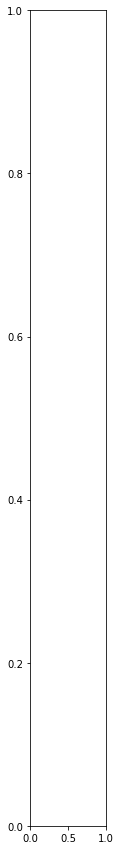

In [23]:
#Let's look at these pairs:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

#And let's look at the labels (0 means "different", 1 means "same"):

y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

c. Train the DNN on this training set. For each image pair, you can simultaneously feed
the first image to DNN A and the second image to DNN B. The whole network will
gradually learn to tell whether two images belong to the same class or not.

#Let's generate a test set composed of many pairs of images pulled from the MNIST test set:

X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

And now, let's train the model. There's really nothing special about this step, except for the fact that we need a fairly large batch_size, otherwise the model fails to learn anything and ends up with an accuracy of 50%:

n_epochs = 100
batch_size = 500
import tensorflow as tf

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 Train loss: 0.69103277
0 Test accuracy: 0.542
1 Train loss: 0.6035354
2 Train loss: 0.54946035
3 Train loss: 0.47047246
4 Train loss: 0.4060757
5 Train loss: 0.38308156
5 Test accuracy: 0.824
6 Train loss: 0.39047274
7 Train loss: 0.3390794
8 Train loss: 0.3210671
9 Train loss: 0.31792685
10 Train loss: 0.24494292
10 Test accuracy: 0.8881
11 Train loss: 0.2929235
12 Train loss: 0.23225449
13 Train loss: 0.23180929
14 Train loss: 0.19877923
15 Train loss: 0.20065464
15 Test accuracy: 0.9203
16 Train loss: 0.19700499
17 Train loss: 0.18893136
18 Train loss: 0.19965452
19 Train loss: 0.24071647
20 Train loss: 0.18882024
20 Test accuracy: 0.9367
21 Train loss: 0.12419197
22 Train loss: 0.14013417
23 Train loss: 0.120789476
24 Train loss: 0.15721135
25 Train loss: 0.11507861
25 Test accuracy: 0.948
26 Train loss: 0.13891116
27 Train loss: 0.1526081
28 Train loss: 0.123436704
<<50 more lines>>
70 Test accuracy: 0.9743
71 Train loss: 0.019732744
72 Train loss: 0.039464083
73 Train loss: 0.04187814
74 Train loss: 0.05303406
75 Train loss: 0.052625064
75 Test accuracy: 0.9756
76 Train loss: 0.038283084
77 Train loss: 0.026332883
78 Train loss: 0.07060841
79 Train loss: 0.03239444
80 Train loss: 0.03136283
80 Test accuracy: 0.9731
81 Train loss: 0.04390848
82 Train loss: 0.015268046
83 Train loss: 0.04875638
84 Train loss: 0.029360933
85 Train loss: 0.0418443
85 Test accuracy: 0.9759
86 Train loss: 0.018274888
87 Train loss: 0.038872603
88 Train loss: 0.02969683
89 Train loss: 0.020990817
90 Train loss: 0.045234833
90 Test accuracy: 0.9769
91 Train loss: 0.039237432
92 Train loss: 0.031329047
93 Train loss: 0.033414133
94 Train loss: 0.025883088
95 Train loss: 0.019567214
95 Test accuracy: 0.9765
96 Train loss: 0.020650322
97 Train loss: 0.0339851
98 Train loss: 0.047079965
99 Train loss: 0.03125228

We have reached 97.6% accuracy on this digit comparison task. That's not bad, this model knows a thing or two about comparing handwritten digits.

Let's see if some of that knowledge can be useful for the regular MNIST classification task.

d. Now create a new DNN by reusing and freezing the hidden layers of DNN A and
adding a softmax output layer on top with 10 neurons. Train this network on split #2
and see if you can achieve high performance despite having only 500 images per
class.

Let's create the model, it is pretty straightforward. There are many ways to freeze the lower layers, as explained in the book. In this example, we chose to use the tf.stop_gradient() function. Note that we need one Saver to restore the pretrained DNN A, and another Saver to save the final model:

reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(frozen_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

Now on to training! We first initialize all variables (including the variables in the new output layer), then we restore the pretrained DNN A. Next, we just train the model on the small MNIST dataset (containing just 5,000 images):

n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9455
10 Test accuracy: 0.9634
20 Test accuracy: 0.9659
30 Test accuracy: 0.9656
40 Test accuracy: 0.9655
50 Test accuracy: 0.9656
60 Test accuracy: 0.9655
70 Test accuracy: 0.9656
80 Test accuracy: 0.9654
90 Test accuracy: 0.9654

Well, 96.5% accuracy, that's not the best MNIST model we have trained so far, but recall that we are only using a small training set (just 500 images per digit). Let's compare this result with the same DNN trained from scratch, without using transfer learning:

reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 Test accuracy: 0.8694
10 Test accuracy: 0.9276
20 Test accuracy: 0.9299
30 Test accuracy: 0.935
40 Test accuracy: 0.942
50 Test accuracy: 0.9435
60 Test accuracy: 0.9442
70 Test accuracy: 0.9447
80 Test accuracy: 0.9448
90 Test accuracy: 0.945
100 Test accuracy: 0.945
110 Test accuracy: 0.9458
120 Test accuracy: 0.9456
130 Test accuracy: 0.9458
140 Test accuracy: 0.9458

Only 94.6% accuracy... So transfer learning helped us reduce the error rate from 5.4% to 3.5% (that's over 35% error reduction). Moreover, the model using transfer learning reached over 96% accuracy in less than 10 epochs.